In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import warnings
from pathlib import Path


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
pd.set_option('max_columns', 100)
pd.set_option('display.precision', 4)

rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
sns.set(font_scale=2.5)

warnings.filterwarnings('ignore')

# 데이터 로드

In [4]:
data_dir = Path('../input/dankook')
sub_dir = Path('../output/')

train_file = data_dir / 'train.csv'
test_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'
sub_file = sub_dir / 'submission.csv'

SEED = 2020

In [5]:
df_train = pd.read_csv(train_file, index_col=0)
df_test = pd.read_csv(test_file, index_col=0)

# EDA 

boxplot을 이용해서 간단하게 train의 분포를 확인

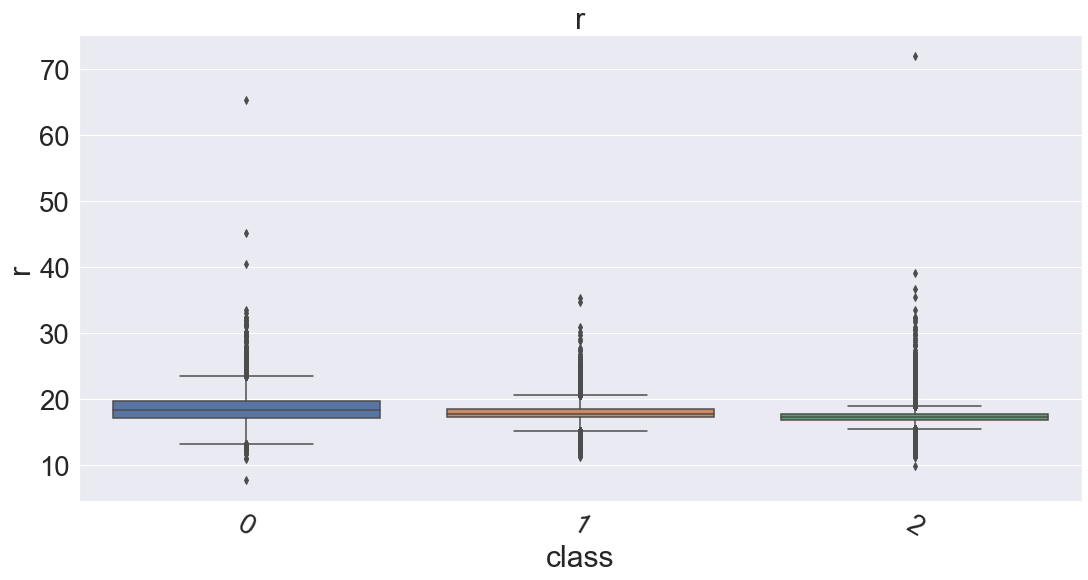

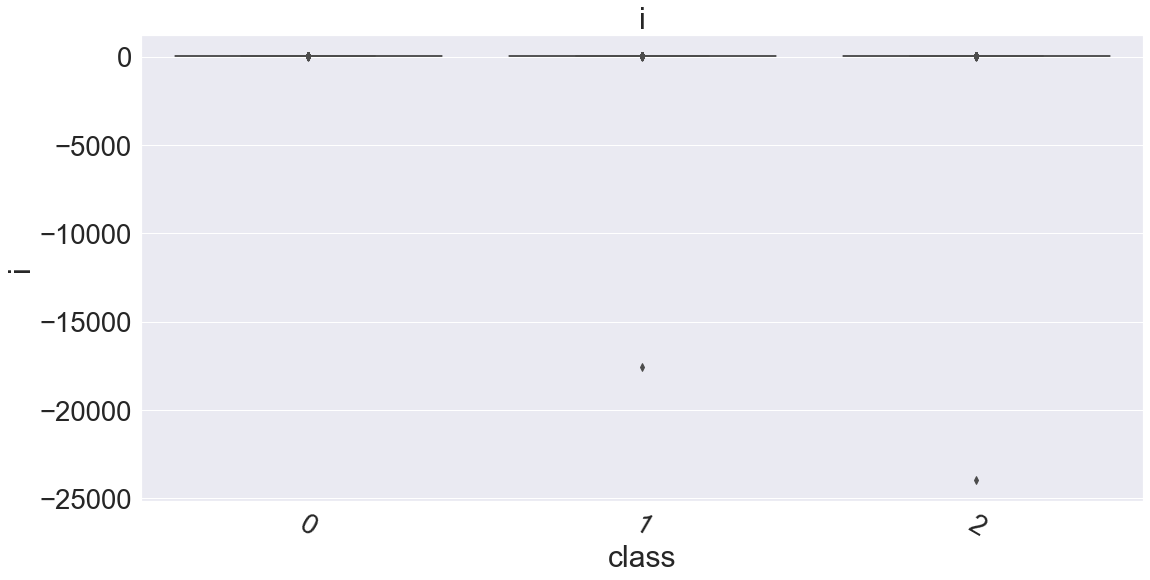

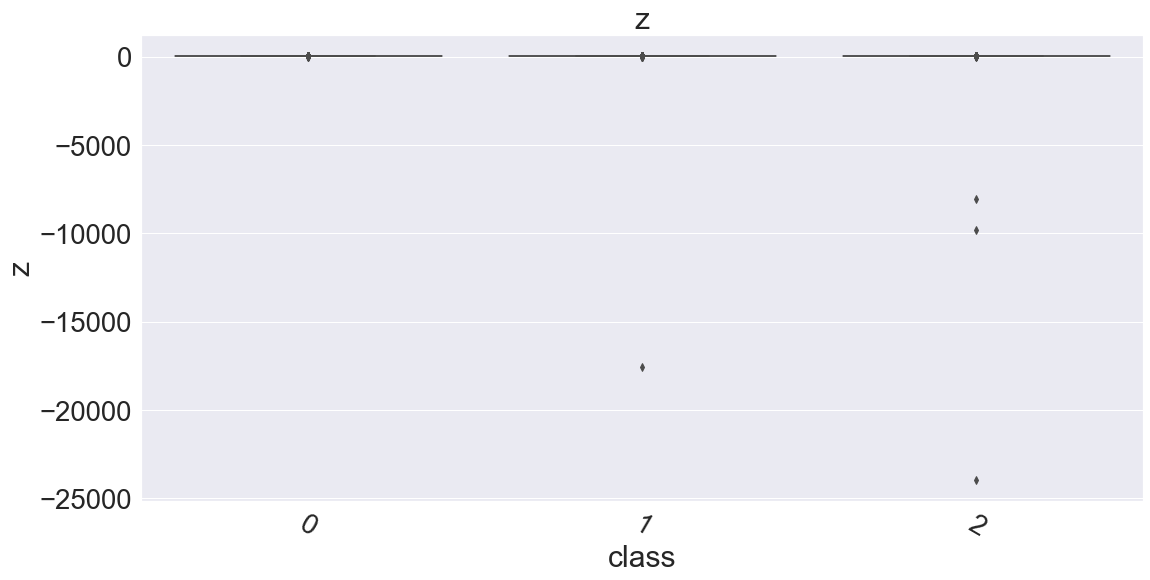

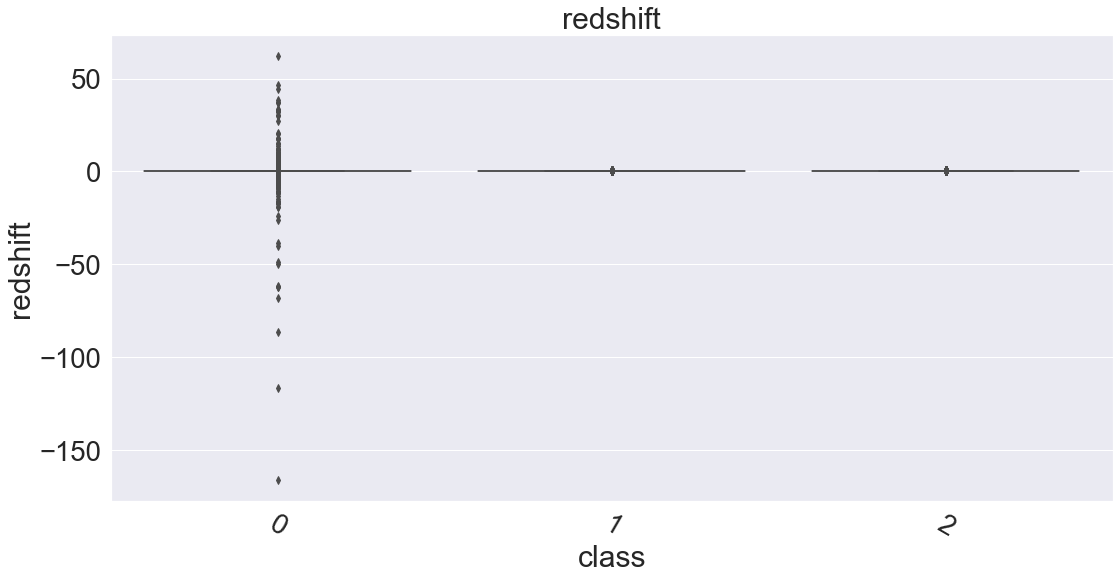

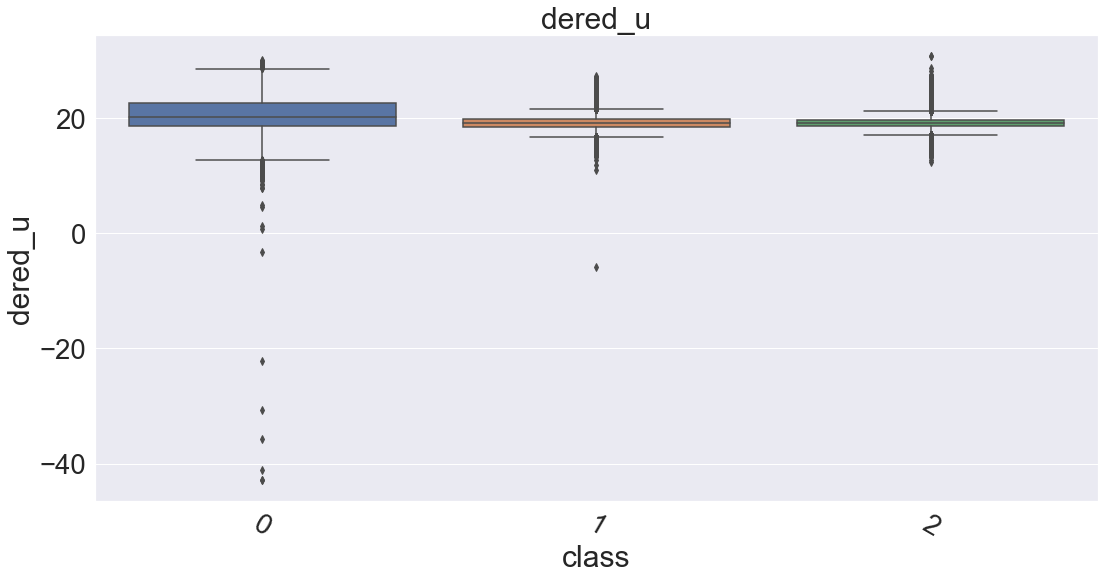

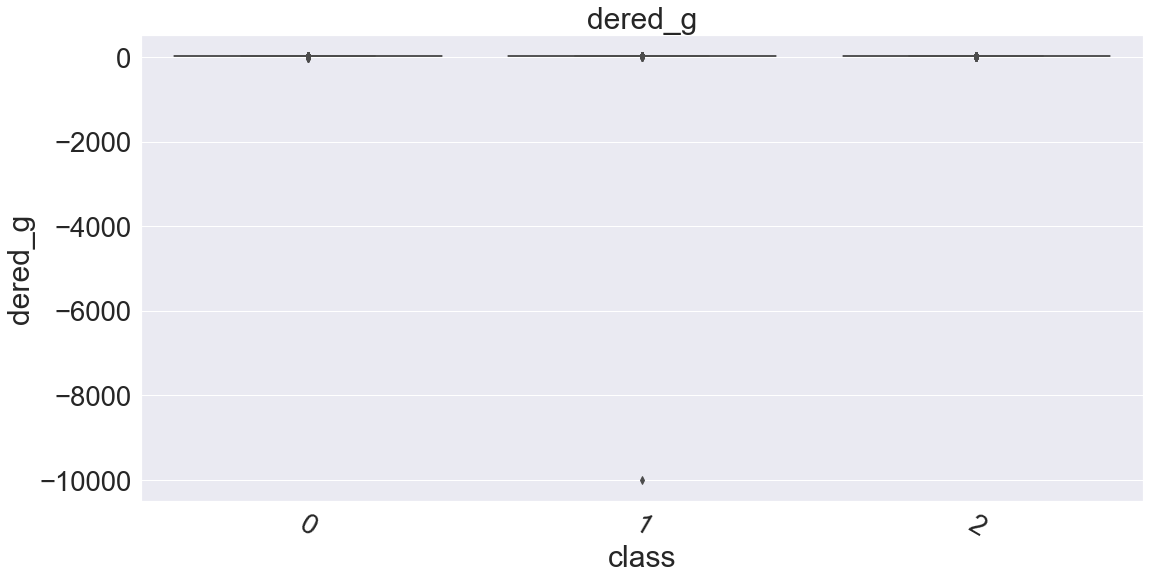

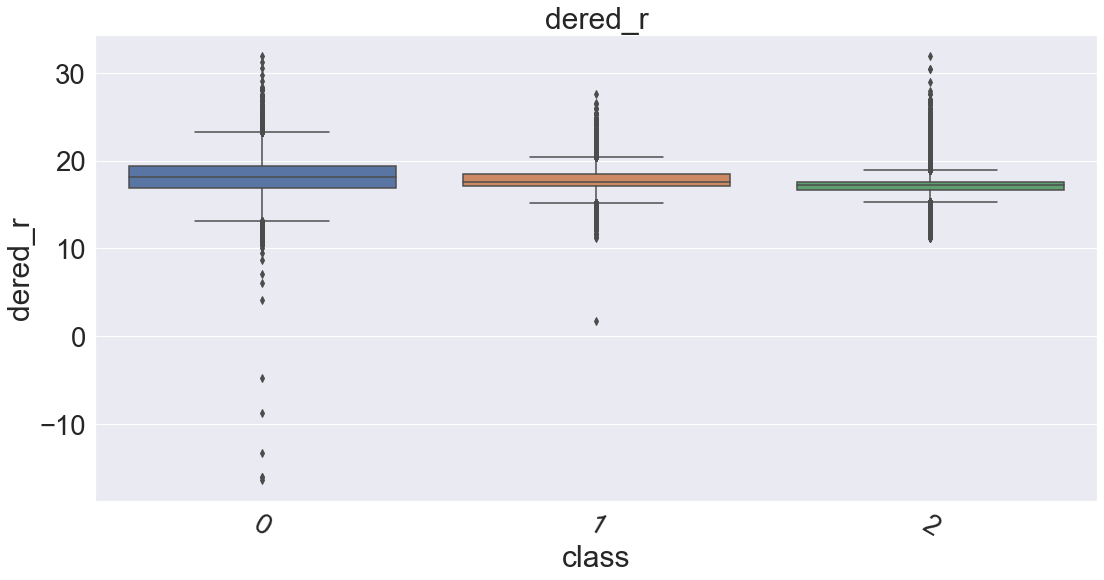

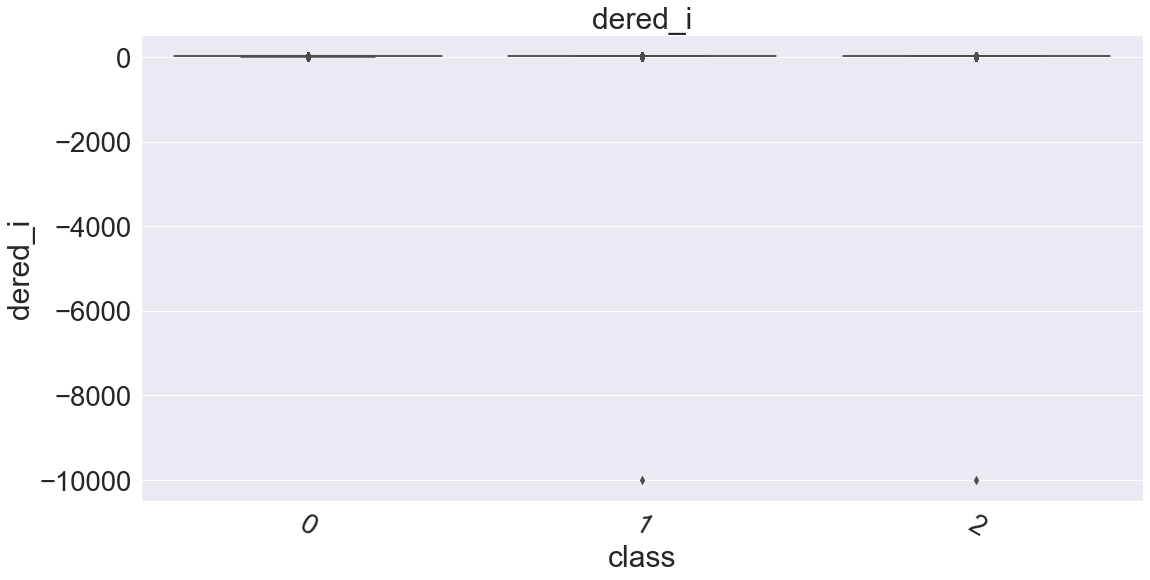

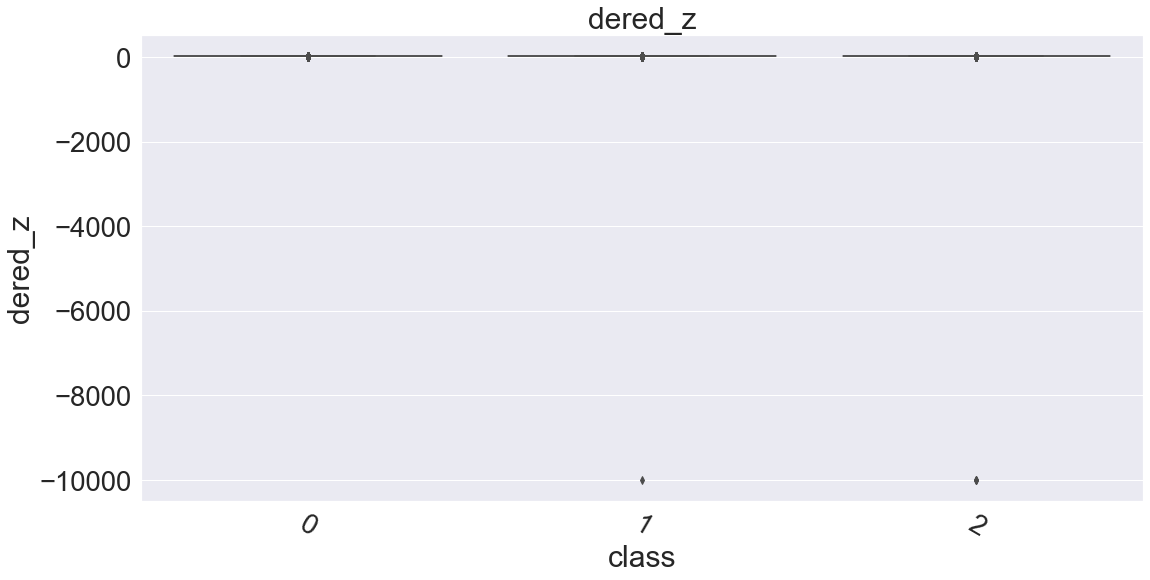

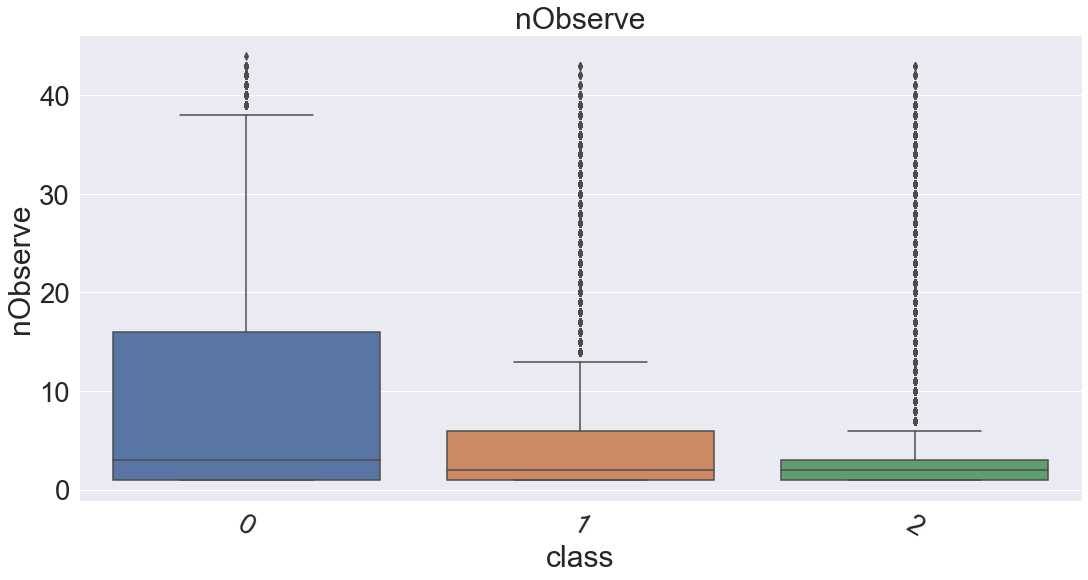

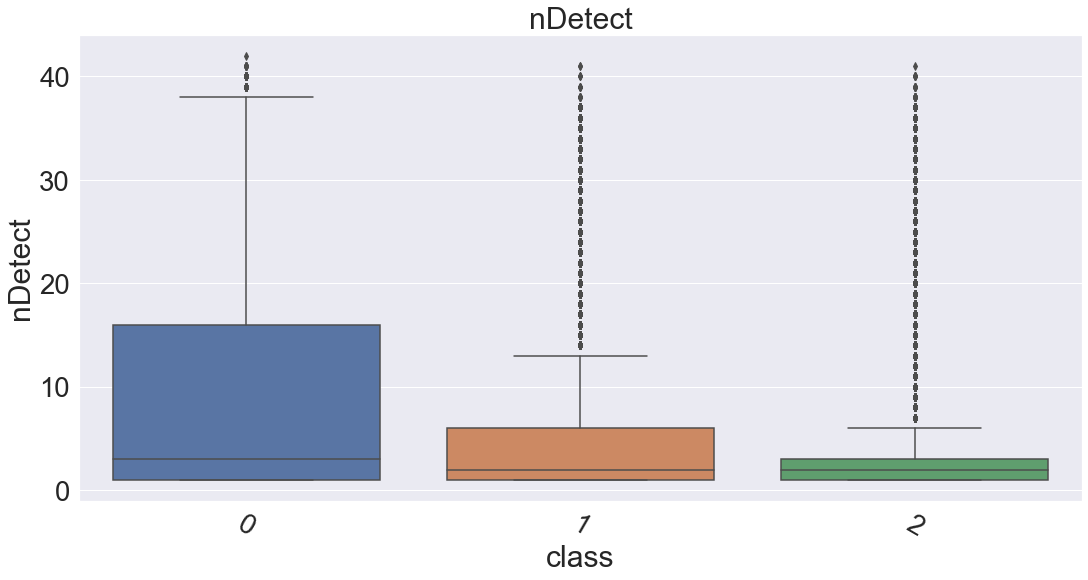

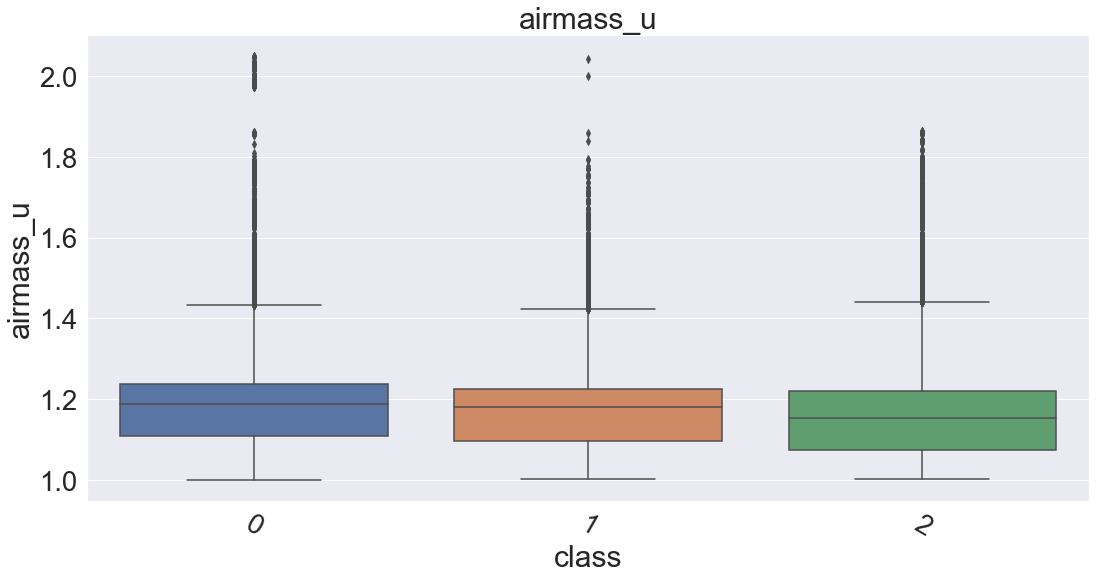

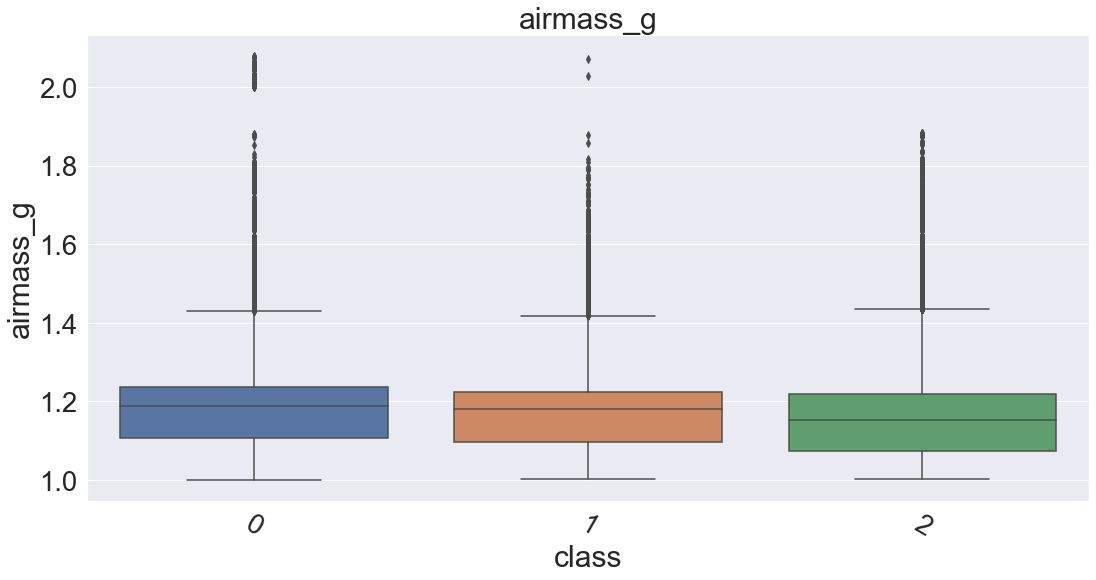

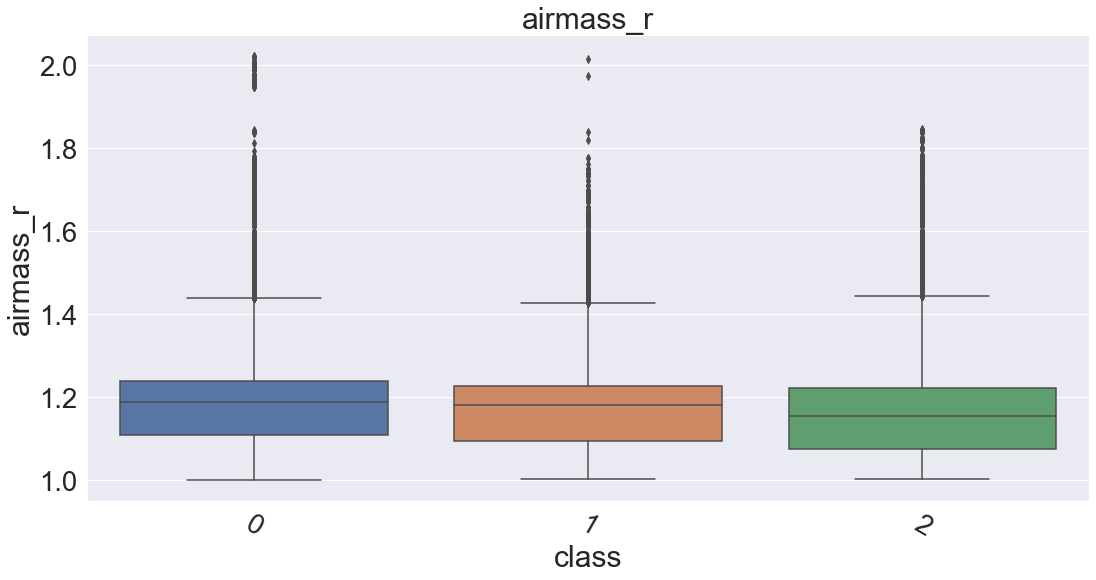

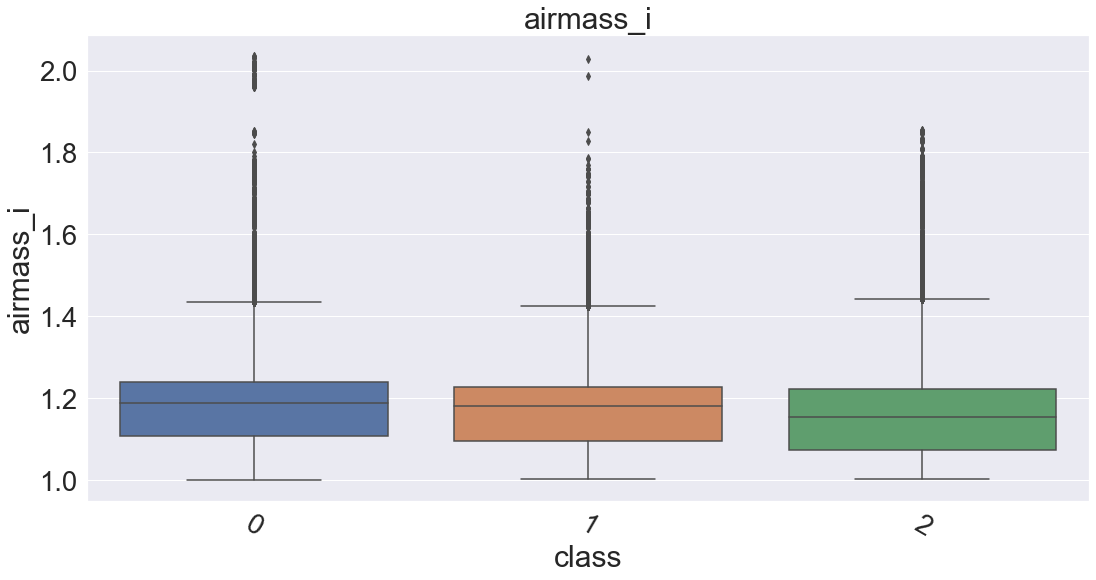

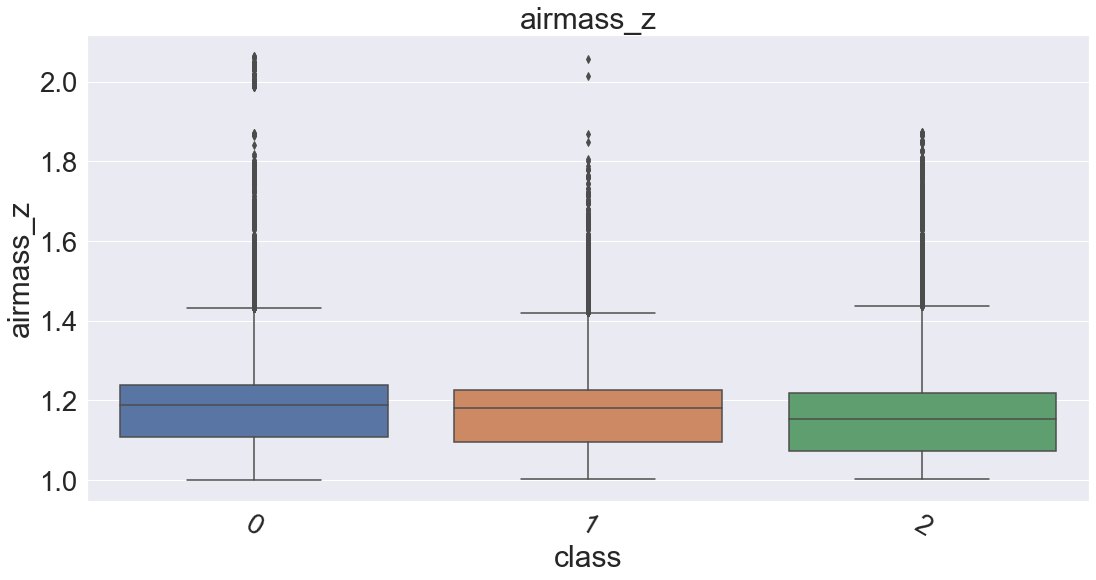

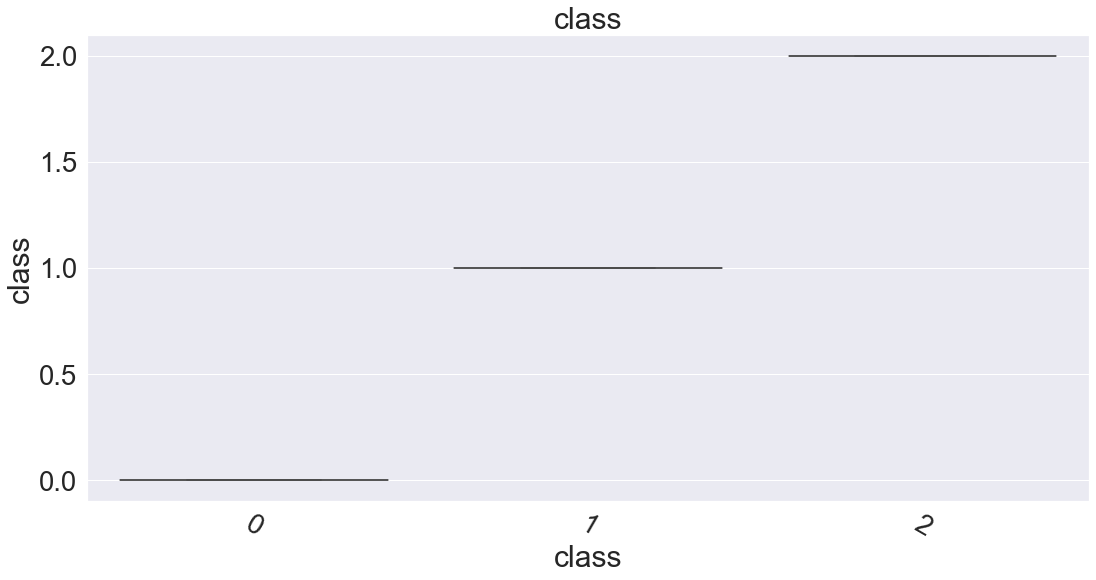

In [6]:
for col in df_train.columns[2:]:
    sns.boxplot(x='class', y=col, data=df_train)
    plt.title(col)
    plt.xticks(rotation=-30)
    plt.show()

이상치 제거전과 이상치 제거후의 train, test의 분포 차이 확인

seaborn의 distplot을 이용하면, 러그 + 커널밀도 + 히스토그램 모두를 표현할 수 있어서 데이터의 전체적인 분포도를 확인할 수 있다.

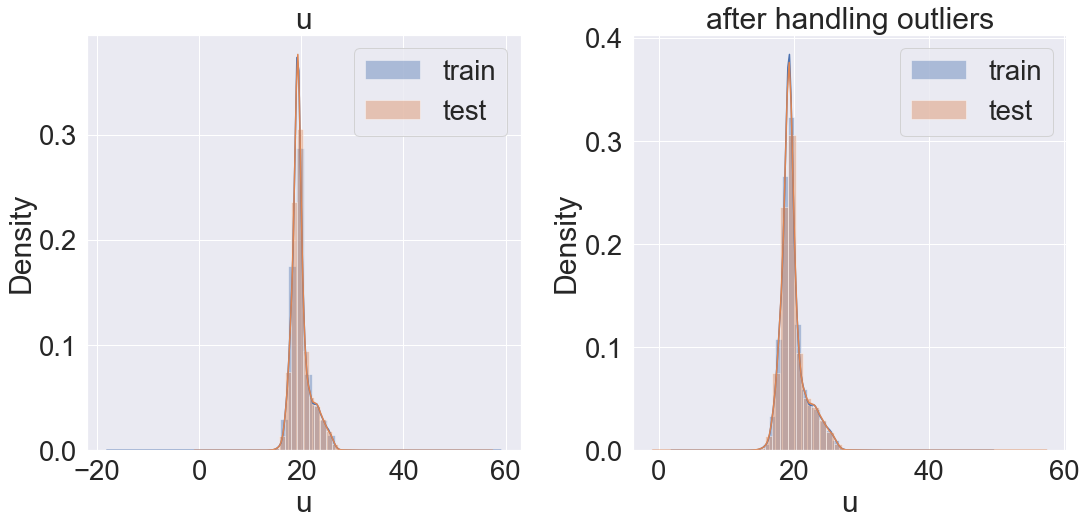

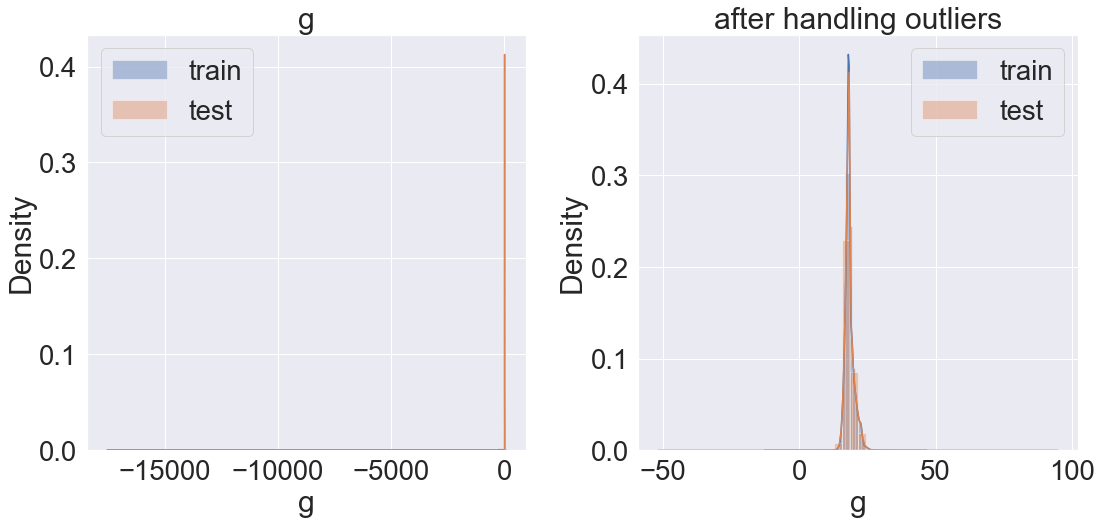

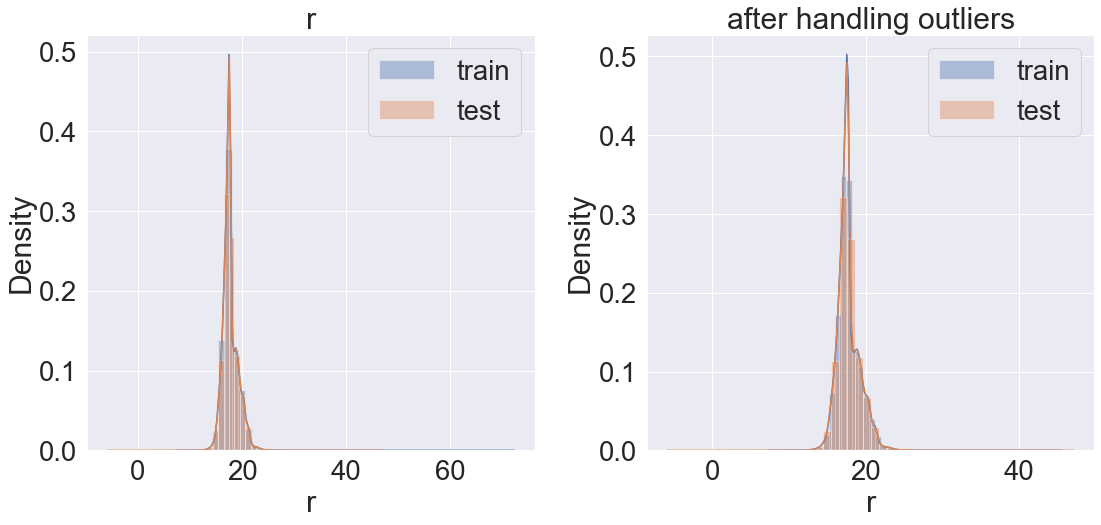

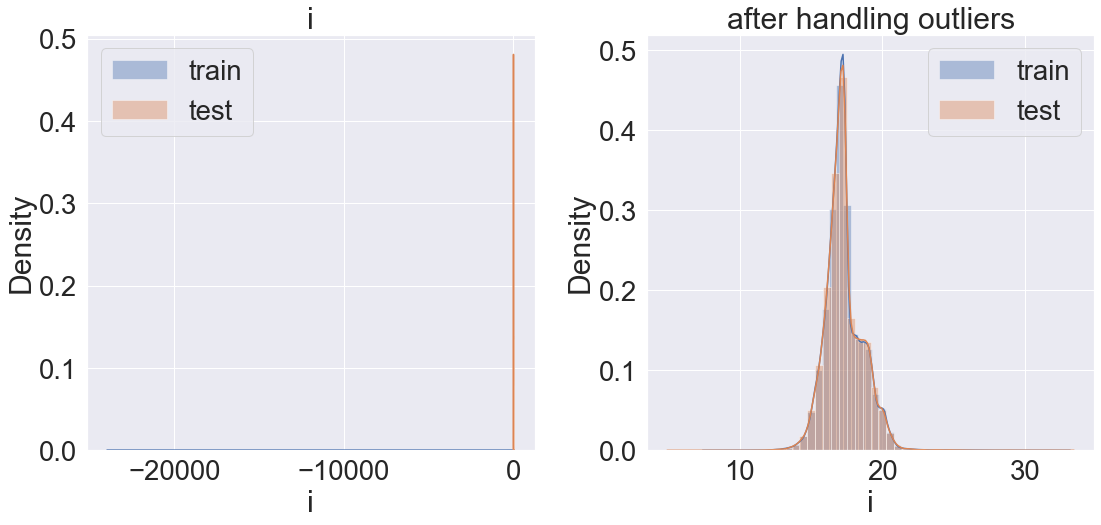

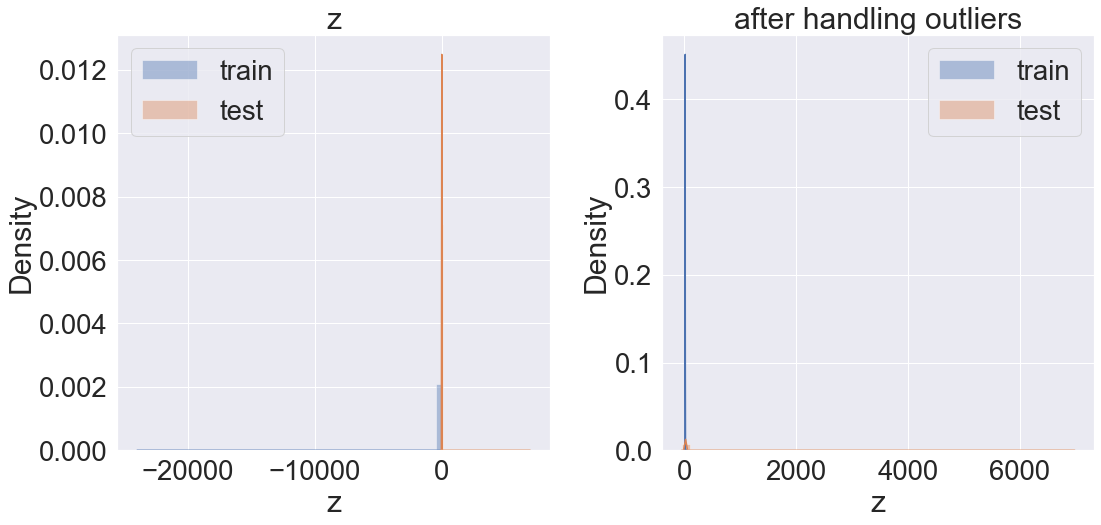

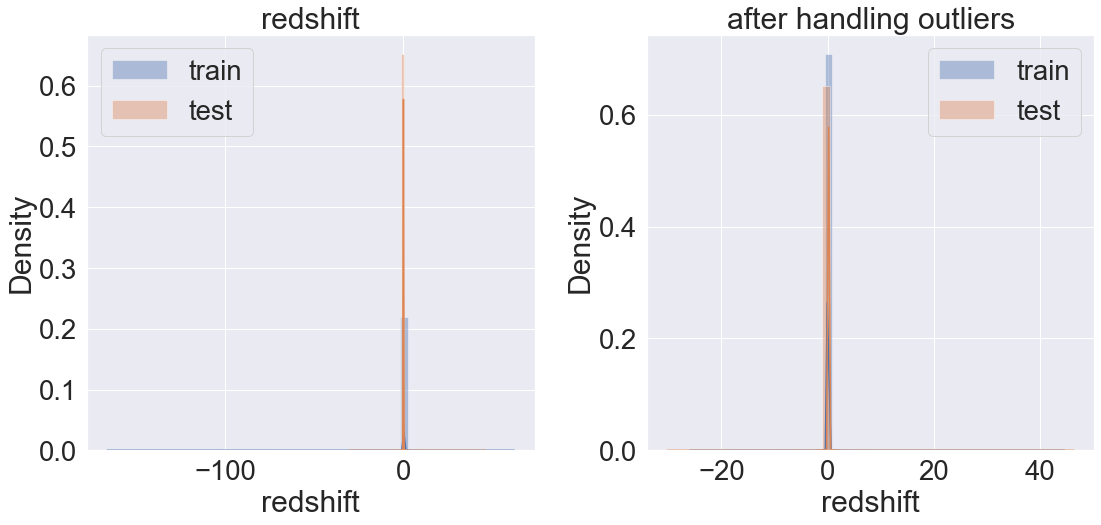

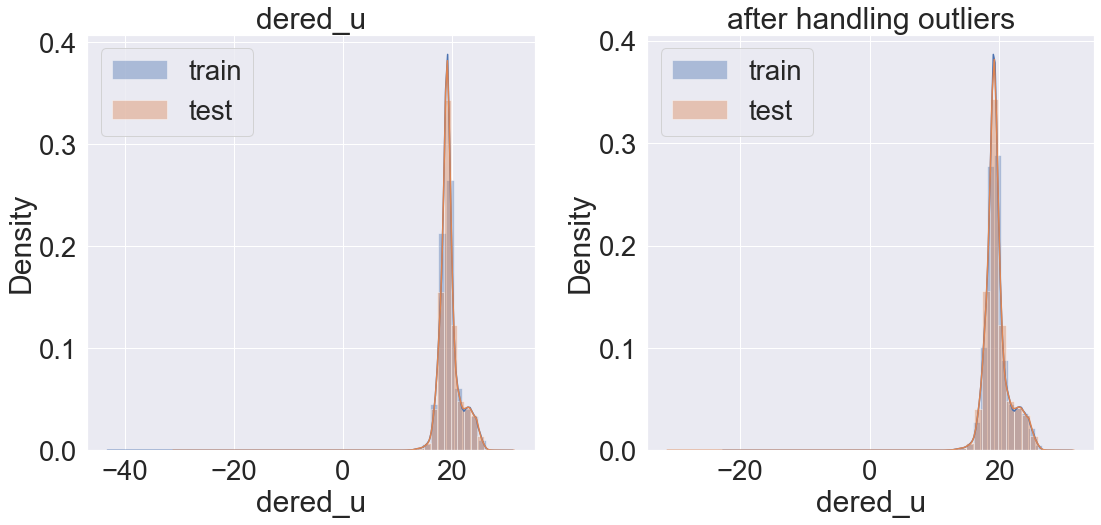

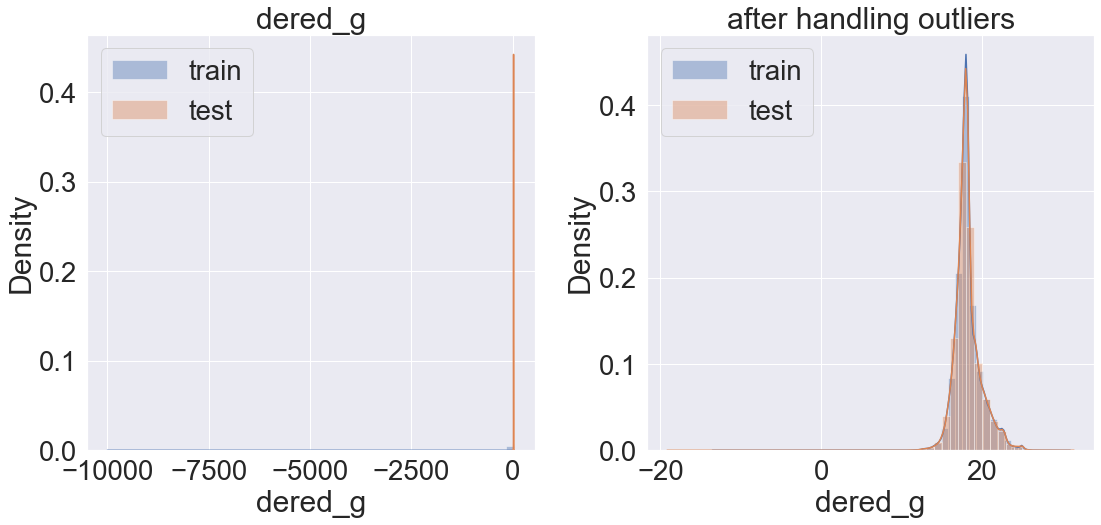

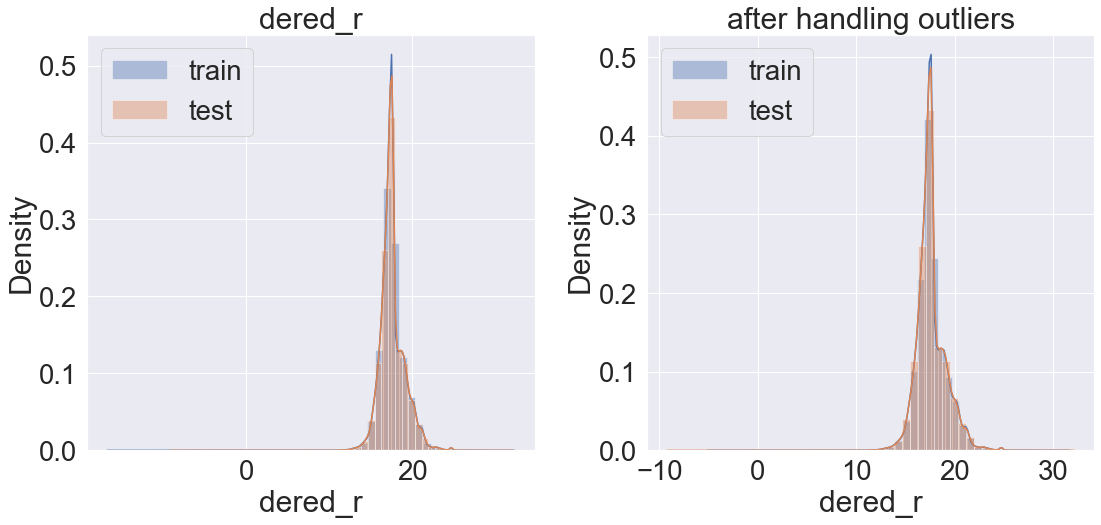

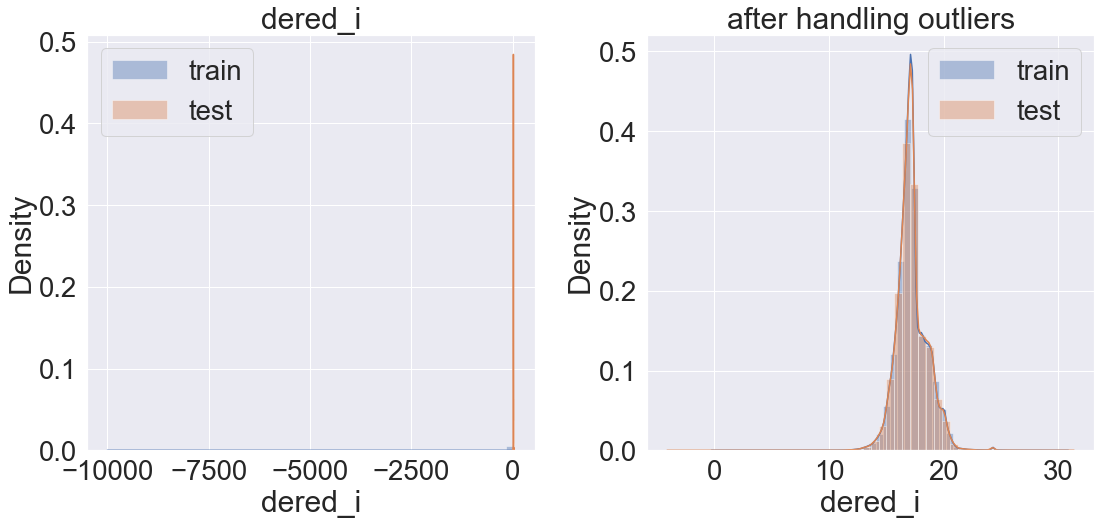

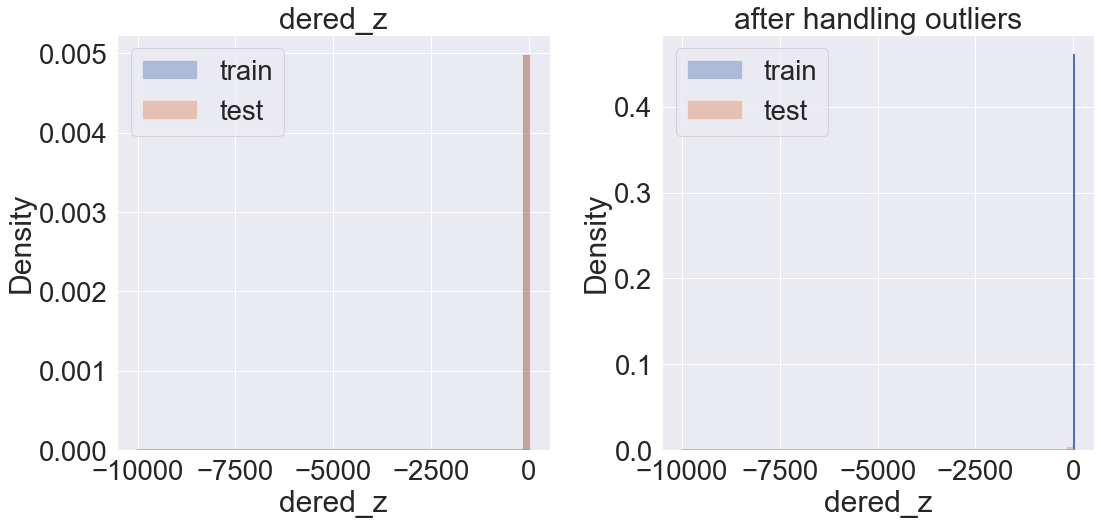

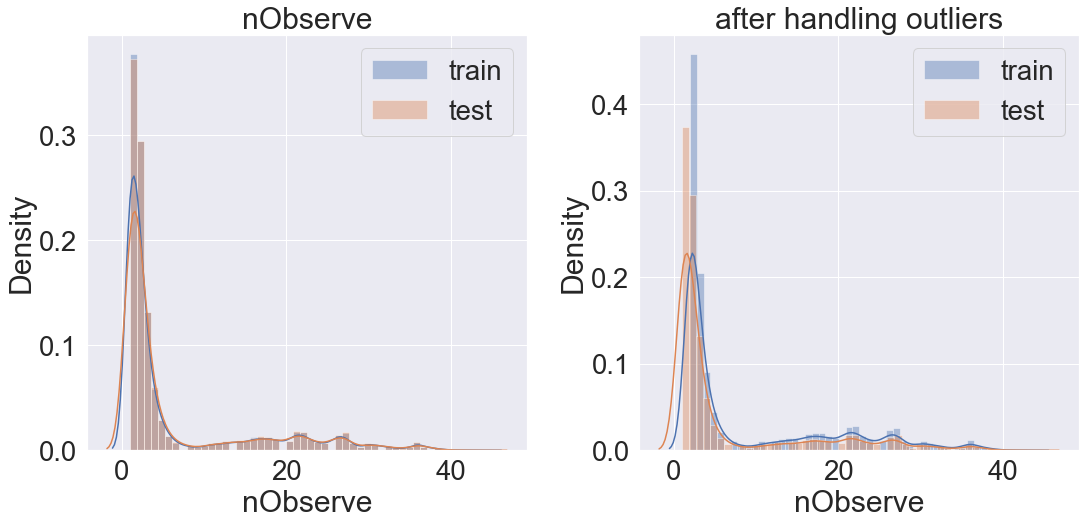

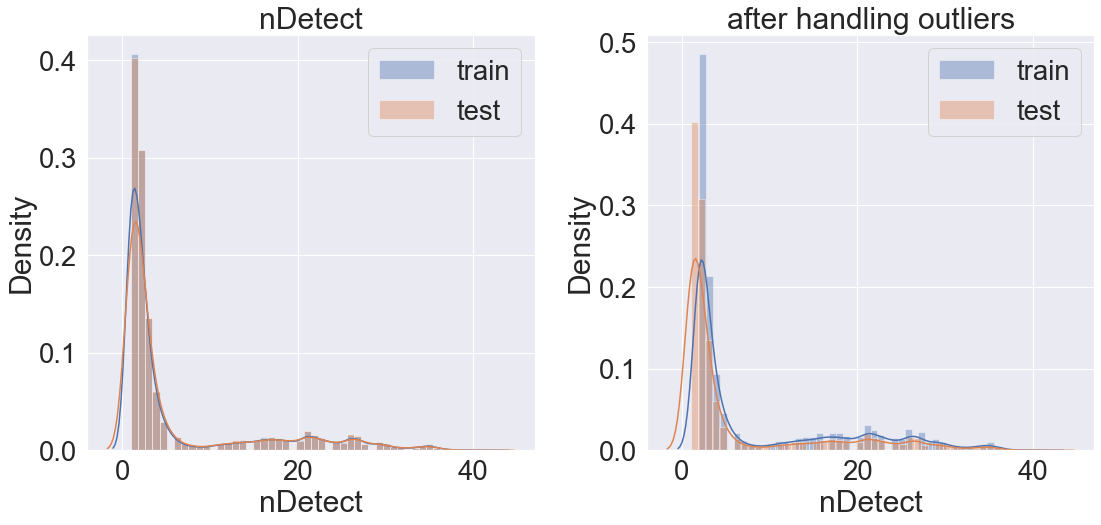

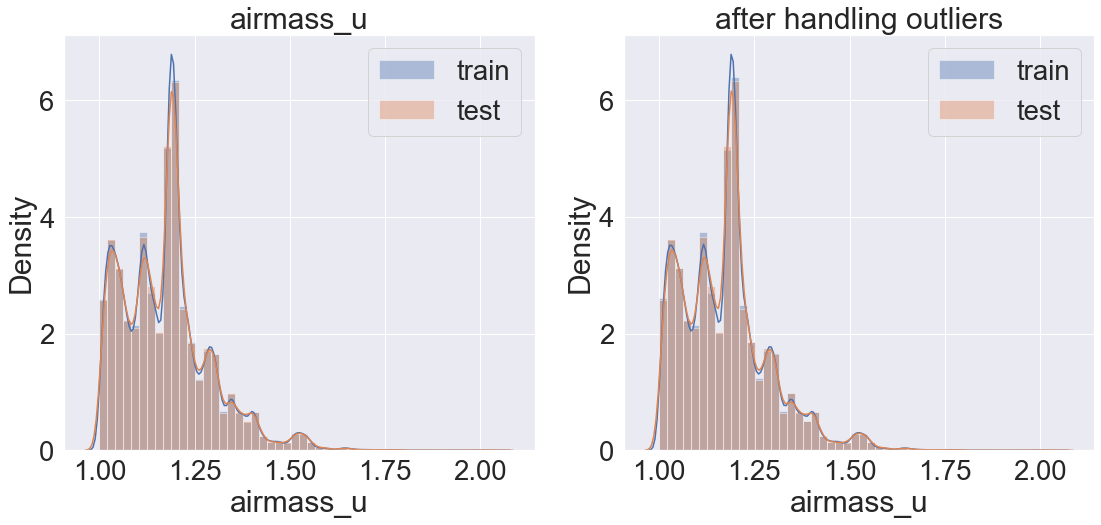

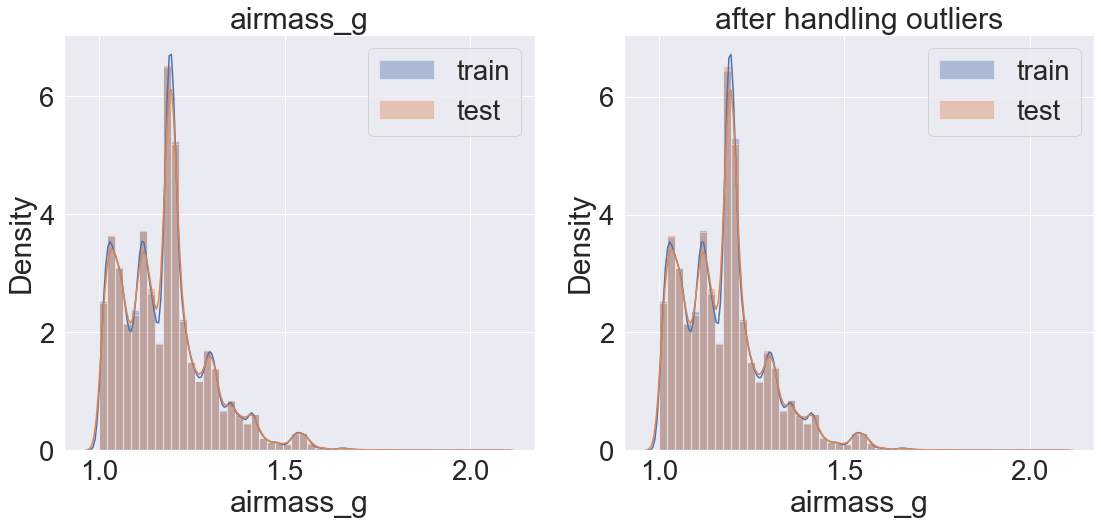

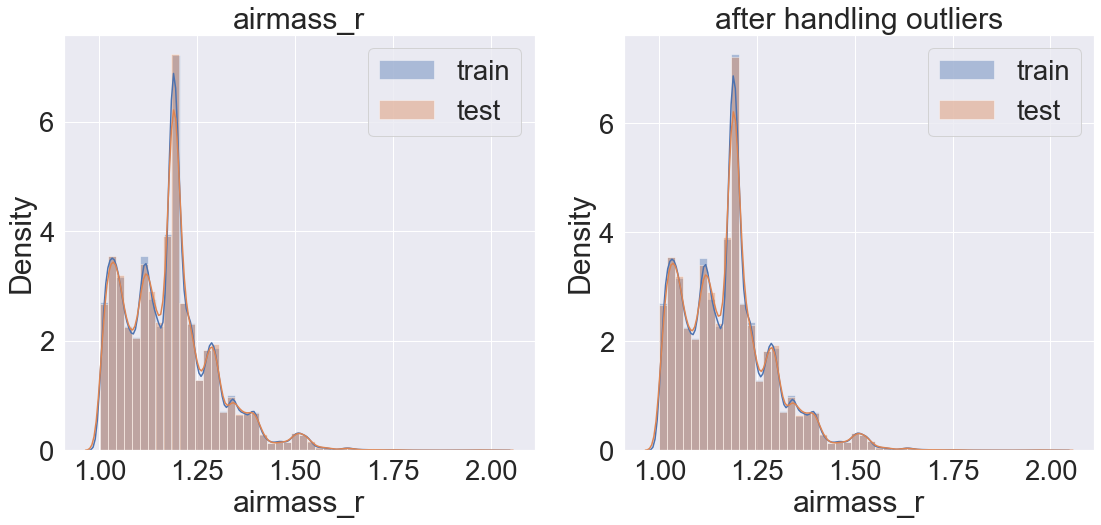

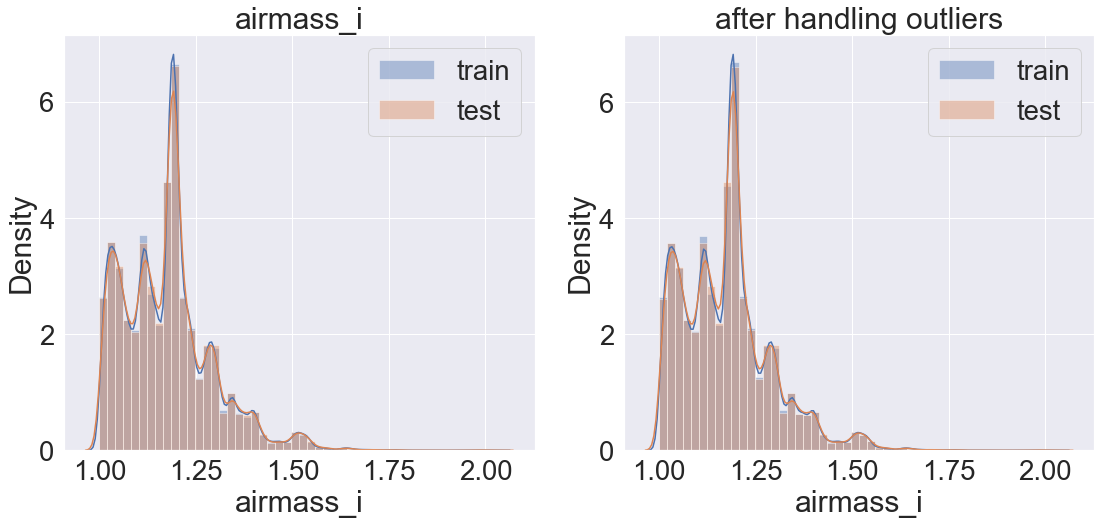

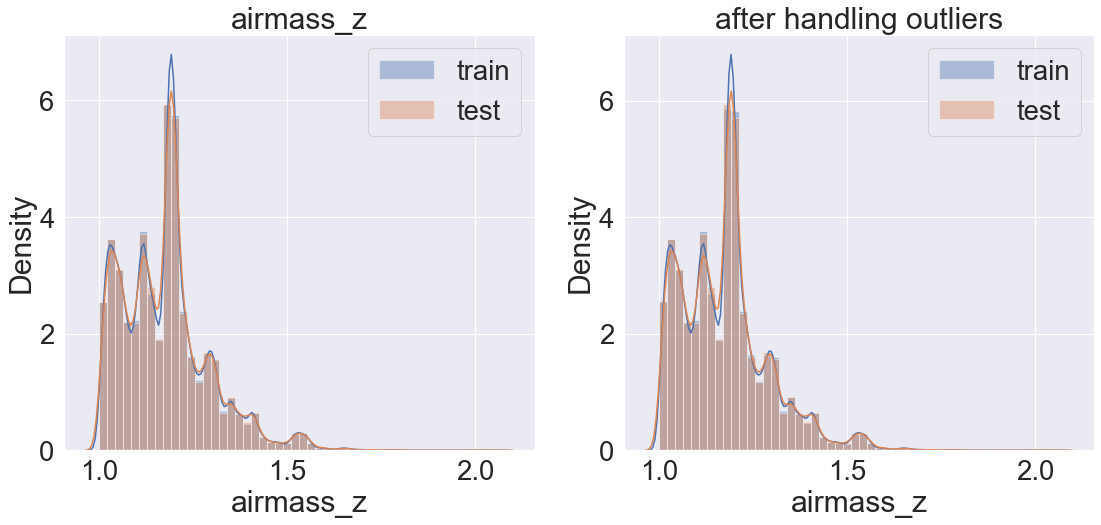

In [7]:
for col in df_train.columns[:18]:
    df = df_train[[col]].loc[np.logical_and(df_train[col]>df_test[col].min(), df_train[col]<df_test[col].max())]
    
    fig, ((ax1,ax2)) = plt.subplots(1,2)
    sns.distplot(df_train[col], label='train', ax=ax1)
    sns.distplot(df_test[col], label='test', ax=ax1)
    sns.distplot(df[col], label='train', ax=ax2)
    sns.distplot(df_test[col], label='test',ax=ax2)

    ax1.set_title(col)
    ax2.set_title('after handling outliers')
    ax1.legend()
    ax2.legend()
    plt.tight_layout()

test의 범위를 넘는 행은 모두 제거

- u,r,z 분포 동일
- g,i 분포 변화


- resdhift 분포 동일


- dered_u, dered_r, dered_z 분포 동일
- dered_g, dered_i 분포 변화


- nObserve, nDetect 분포 동일


- airmass_u, airmass_g, airmass_r, airmass_i, airmass_z 분포 동일

같은 파장대는 동일한 분포를 보여줌.

u는 dered_u와 비슷하고, r은 dered_r와 비슷하고, z는 dered_g와 비슷하고, i는 dered_i와 비슷하고, z는 dered_z와 비슷함.

nObserve, nDetect는 또한 동일한 분포를 보여주고 있음.
멱함수 분포 형태로

airmass_u, airmass_g, airmass_r, airmass_i, airmass_z는 동일한 분포를 보여주고 있음.


예측: 이상치 제거후는 다음과 같을듯

u,g,r,i,z는 서로 상관관계가 어느 정도 있음.

X 와 dered_X 는 서로 상관관계가 어느 정도 있음. 

airmass_X 는 서로 상관관계가 매우 높은 것 같음

nDetect, nObserve는 서로 상관관계가 매우 높은 것 같음

# 이상치 제거전 상관관계도

<AxesSubplot:>

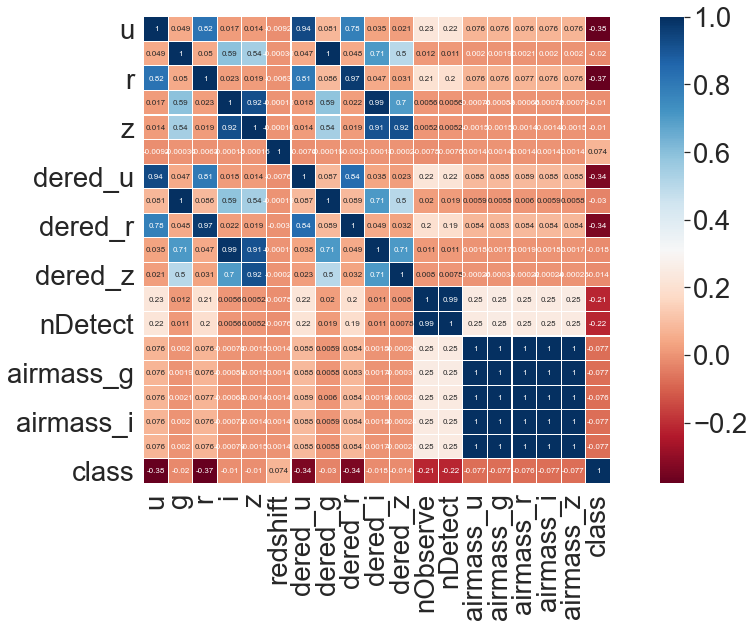

In [8]:
sns.heatmap(df_train.corr(), linewidths=0.1, vmax=1.0, square=True, cmap= plt.cm.RdBu, linecolor='white', annot=True, annot_kws={'size':8})

<AxesSubplot:>

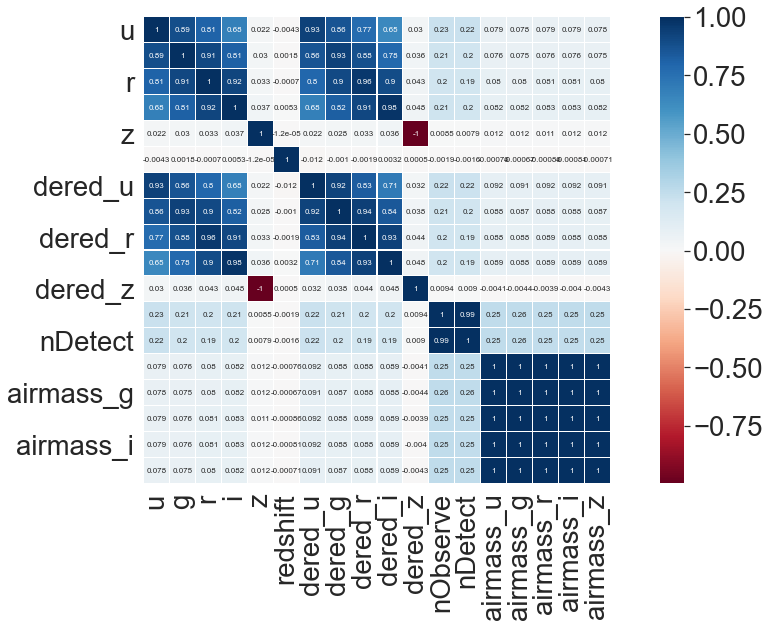

In [9]:
sns.heatmap(df_test.corr(), linewidths=0.1, vmax=1.0, square=True, cmap= plt.cm.RdBu, linecolor='white', annot=True, annot_kws={'size':8})

결론: 이상체 제거전

이상치 제거전에는 u,g,r,i,z는 서로에게 약간의 상관 관계를 가지고 있다.

dered_u, dered_g, dered_r, dered_i, dered_z도 서로에게 약간의 상관관계를 가지고 있다. 그리고 이것들은 위쪽에 언급한 feature하고도 약간의 상관 관계를 가지고 있다.

그리고 nDetect, nObserve는 서로 상관관계가 매우 높다.

그리고 airmass_u, airmass_g, airmass_r, airmass_i, airmass_z는 서로 상관관계가 매우 높다.

마지막으로 나머지 관계들은 서로 상관관계가 낮다.

# 이상치 제거

In [10]:
# test의 MinMax 범위 넘는 행은 train에서 제거
train_shape = df_train.shape[0]

for col in df_train.columns[:18]:
    df_train = df_train.loc[np.logical_and(df_train[col]>=df_test[col].min(),
                            df_train[col]<=df_test[col].max())]

print('제거된 행 개수 :', train_shape - df_train.shape[0])

제거된 행 개수 : 77


제거된 행 개수 가 106,590 생각보다 많이 제거 된 것 같은데..?
320,000 에서 1/3 정도가 날라감.

과연 이상치 제거하는 것이 훈련 샘플 십만개를 날린 효과가 있을까?

# 이상치 제거 후 상관관계도 

<AxesSubplot:>

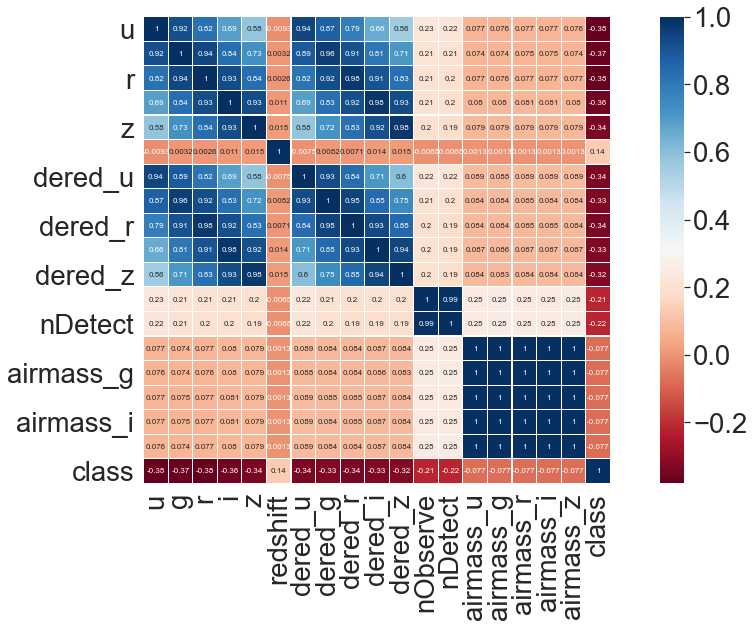

In [11]:
sns.heatmap(df_train.corr(), linewidths=0.1, vmax=1.0, square=True, cmap= plt.cm.RdBu, linecolor='white', annot=True, annot_kws={'size':8})

<AxesSubplot:>

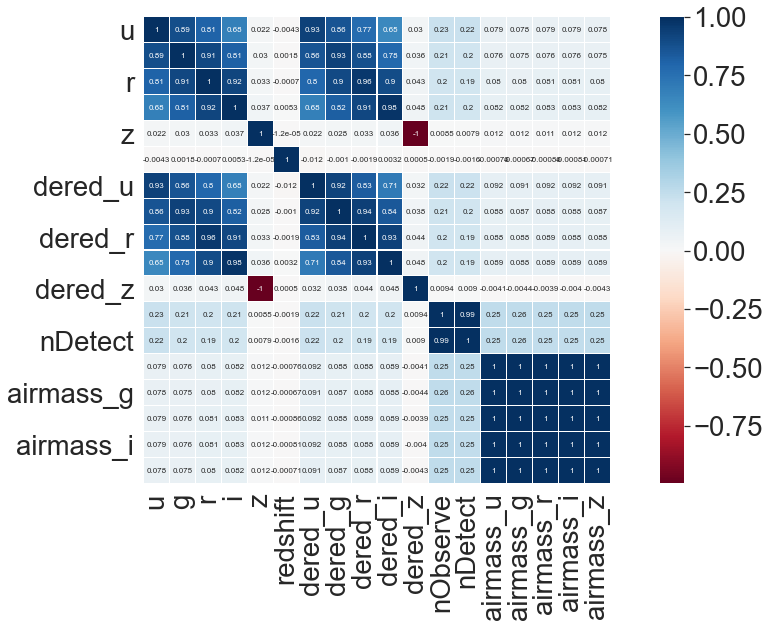

In [12]:
sns.heatmap(df_test.corr(), linewidths=0.1, vmax=1.0, square=True, cmap= plt.cm.RdBu, linecolor='white', annot=True, annot_kws={'size':8})

결론: 이상치 제거 후

예측한대로 u,g,r,i,z는 서로 상관관계가 꽤 많다.
그리고 u,g,r,i,z는 dered_u, dered_g,dered_r,dered_i,dered_z 와도 서로 상관관계가 꽤 많다.

그리고 nDetect, nObserve는 서로 상관관계가 매우 높다.

그리고 airmass_u, airmass_g, airmass_r, airmass_i, airmass_z는 서로 상관관계가 매우 높다.

마지막으로 나머지 관계들은 서로 상관관계가 낮다.

# 이상치 제거 후 EDA

seaborn의 boxplot은 Box-Whisker Plot이라고 불리는 차트를 그려준다.

박스는 실수 값 분포에서 1사분위수(Q1)와 3사분위수(Q3)를 뜻하고 3사분위수와 3사분위수의 차이(Q3-Q1)를 IQR(interquartile range)라고 한다. 박스 내부의 가로선은 중앙값을 나타낸다. 박스 외부의 세로선은 1사분위수보다 1.5 x IQR 만큼 낮은 값과 3사분위수보다 1.5 x IQR 만큼 높은 값의 구간을 기준으로 그 구간의 내부에 있는 가장 큰 데이터와 가장 작은 데이터를 잇는 선분이다. 그 바까의 점은 아웃라이어(outlier)라고 부르는데 일일히 점으로 표시한다.

boxplot은 중앙값, 표준 편차 등, 분포의 간략한 특성을 보여주는데, violinplot 같은 것을 이용하면, 카테고리 값에 따른 각 분포의 실제 데이터나 전체 형상을 보여준다는 장점을 가지고 있음.

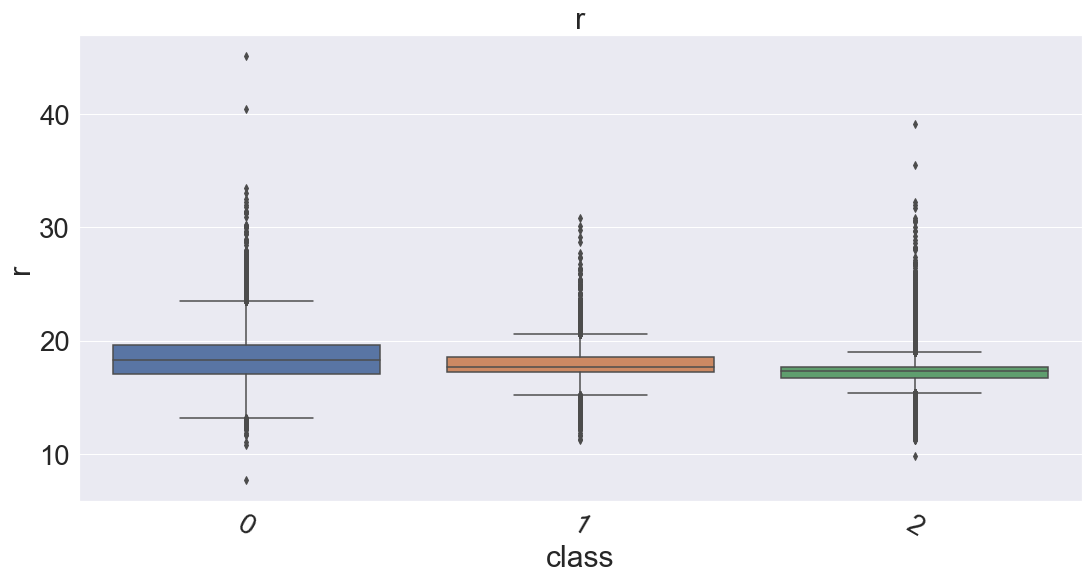

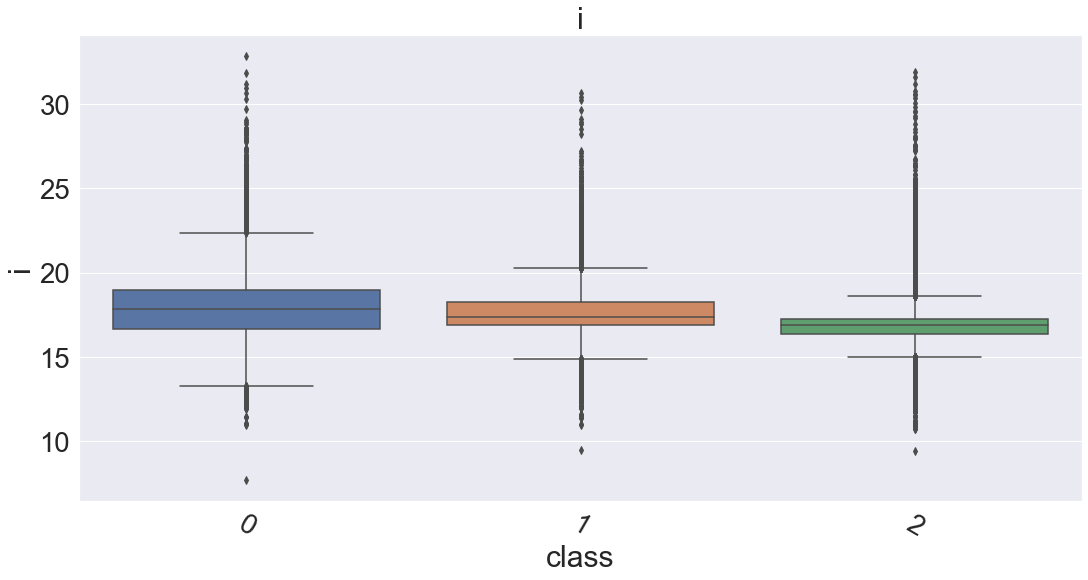

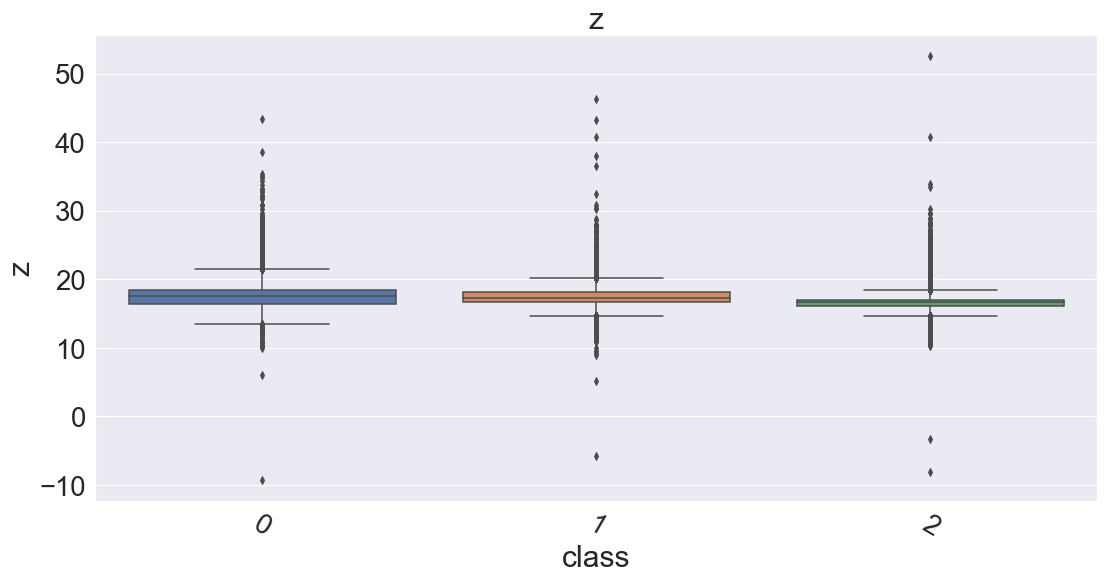

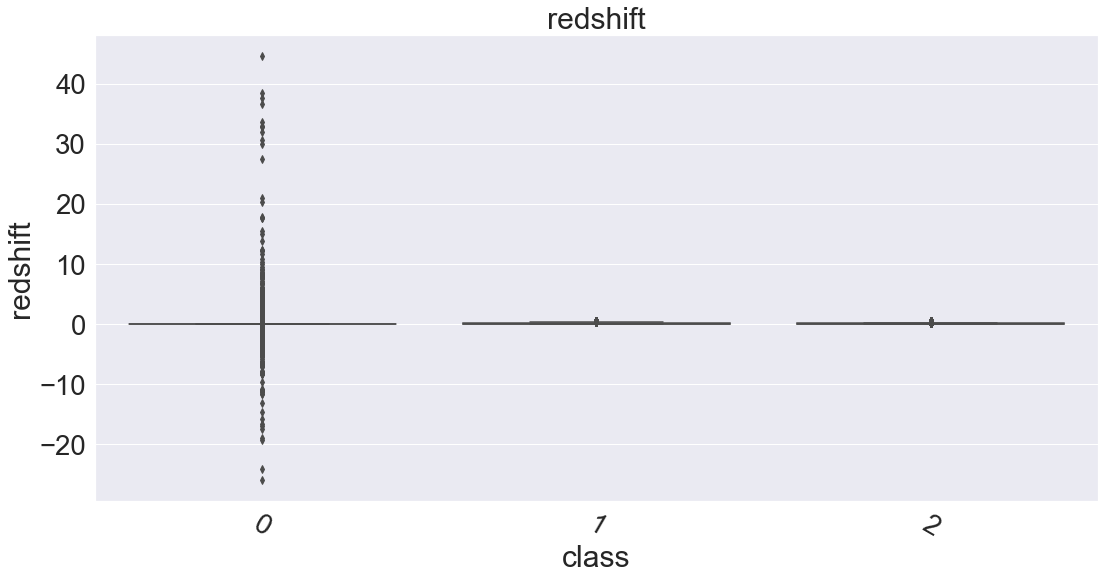

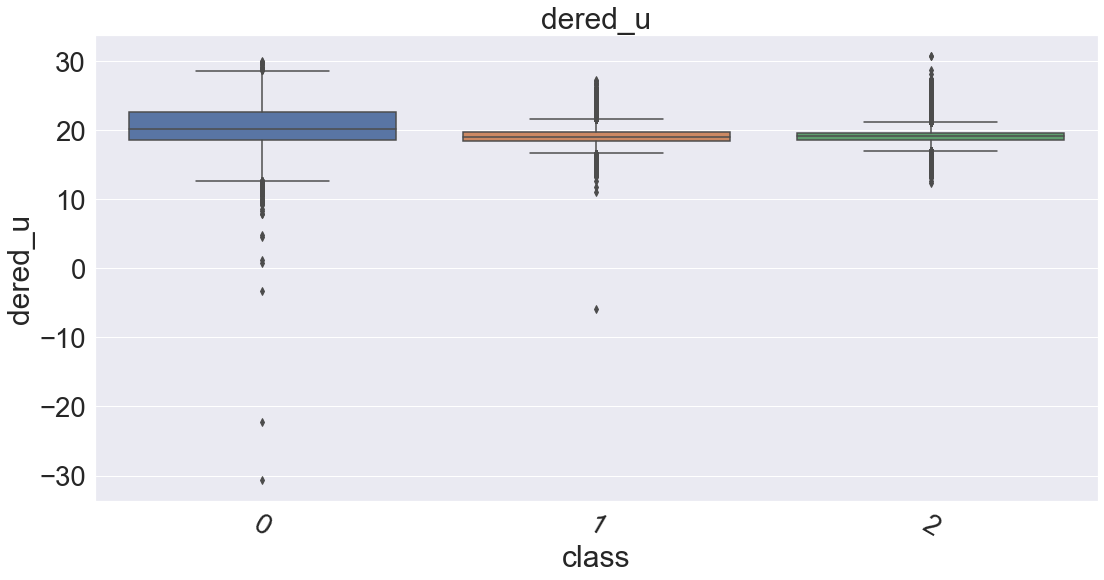

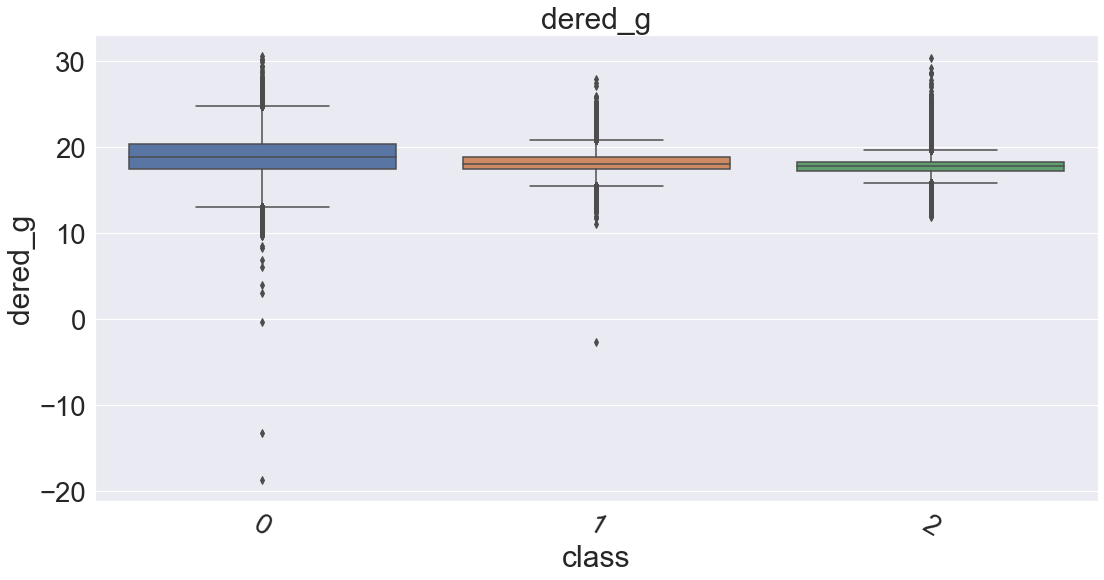

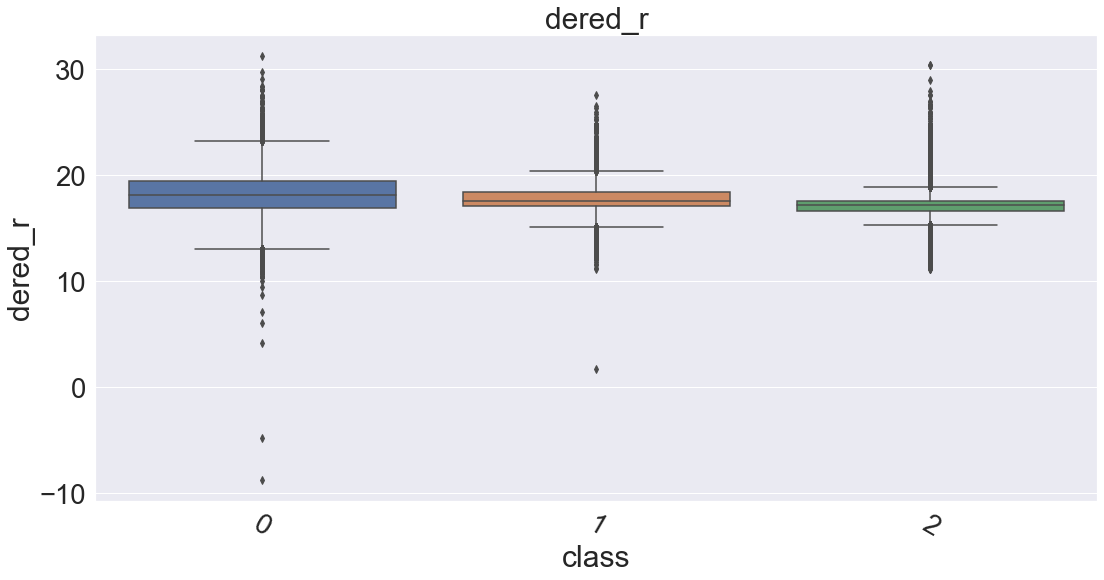

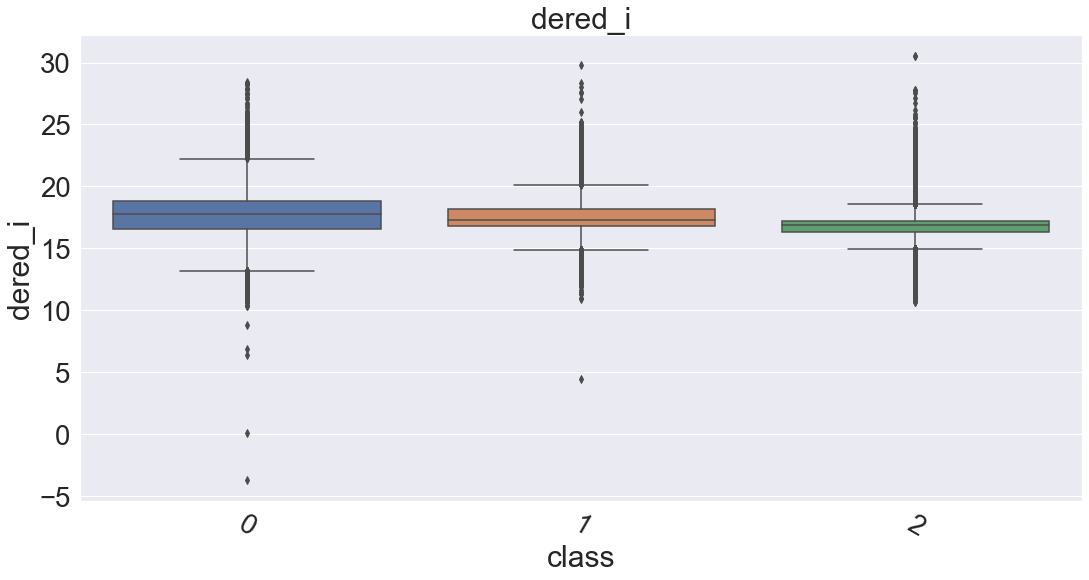

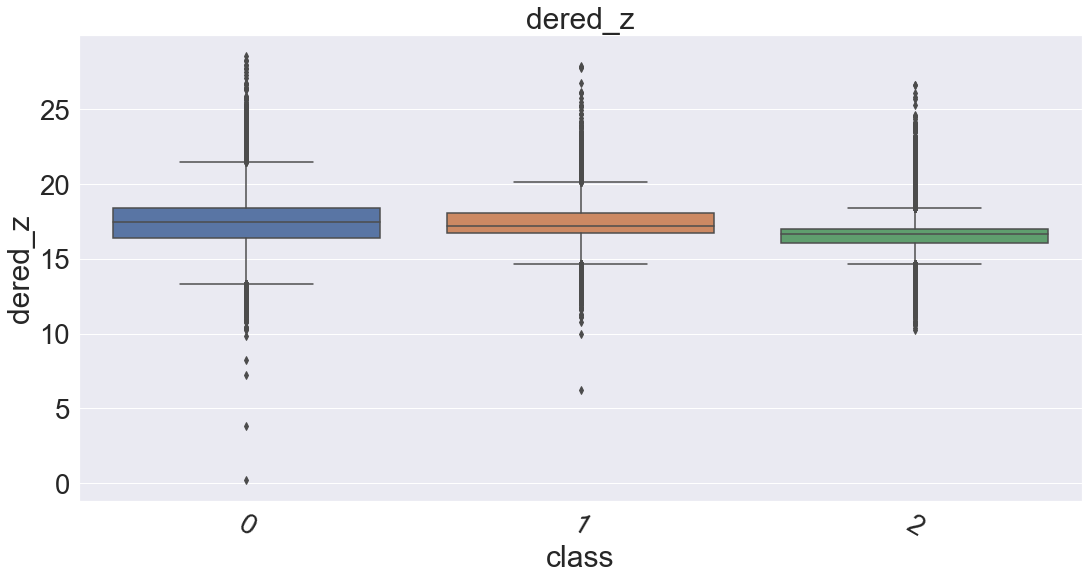

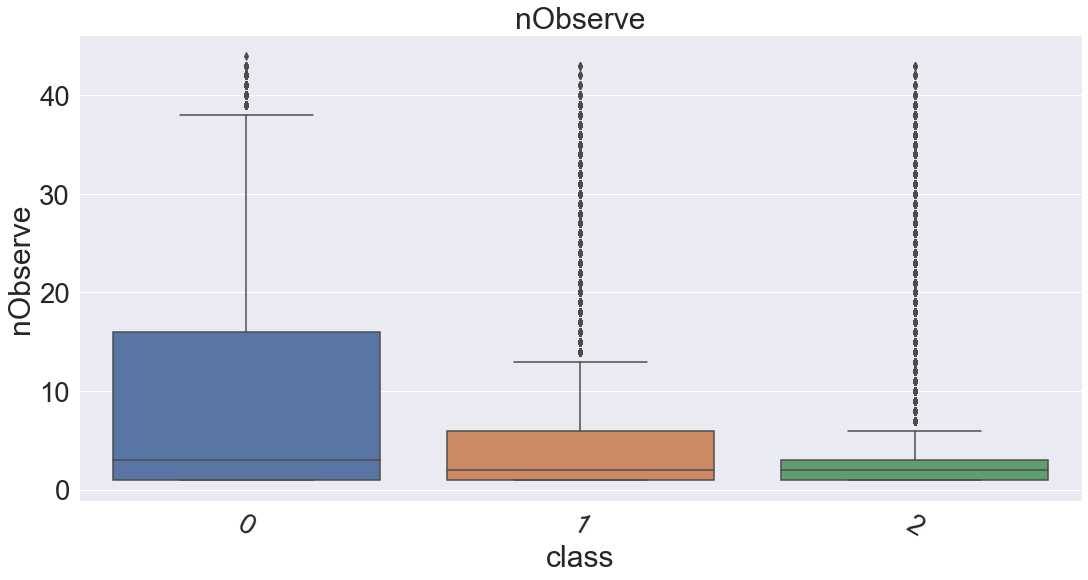

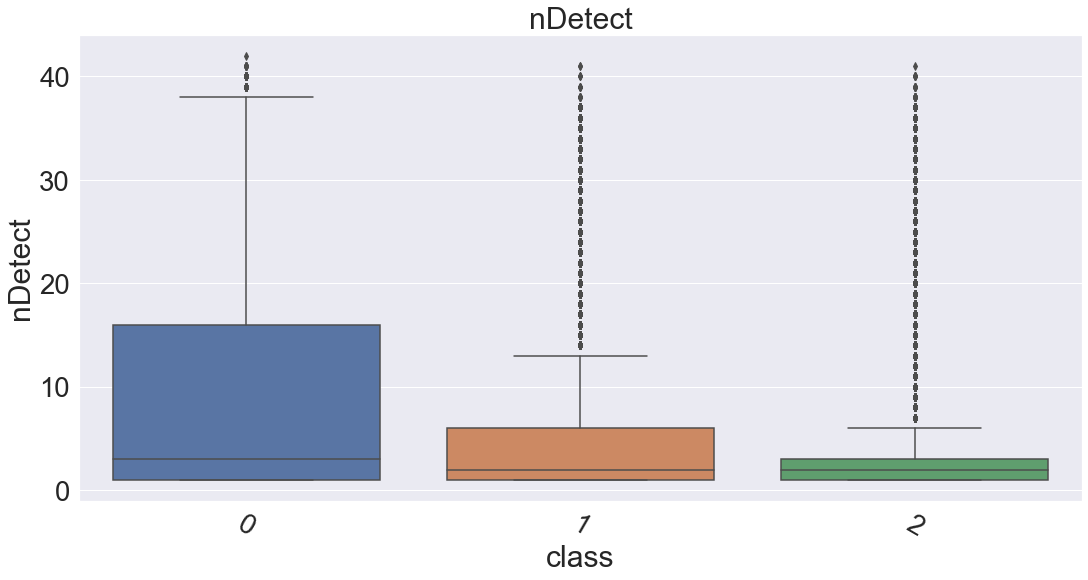

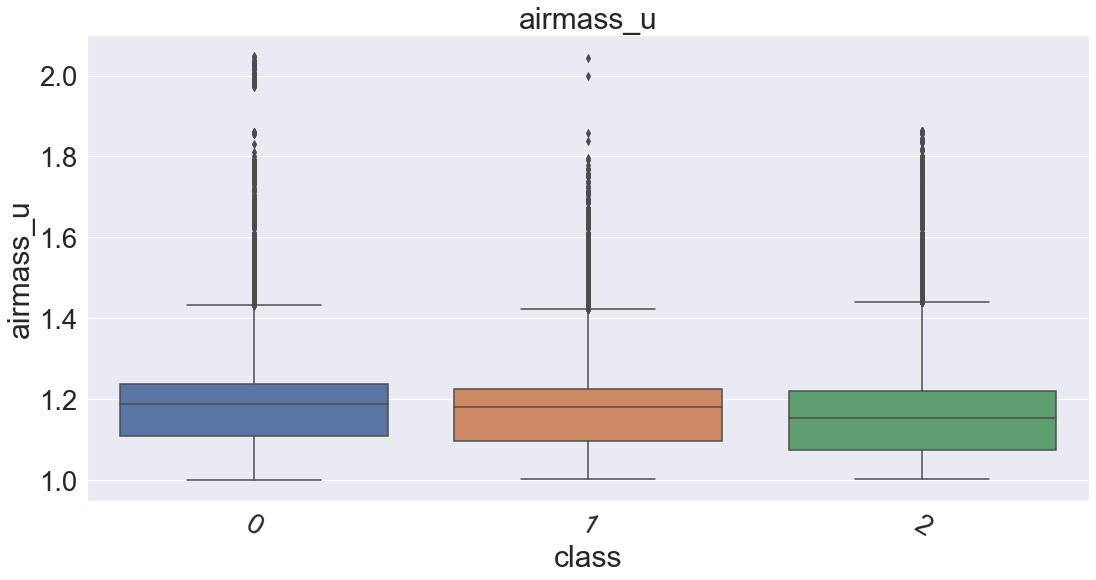

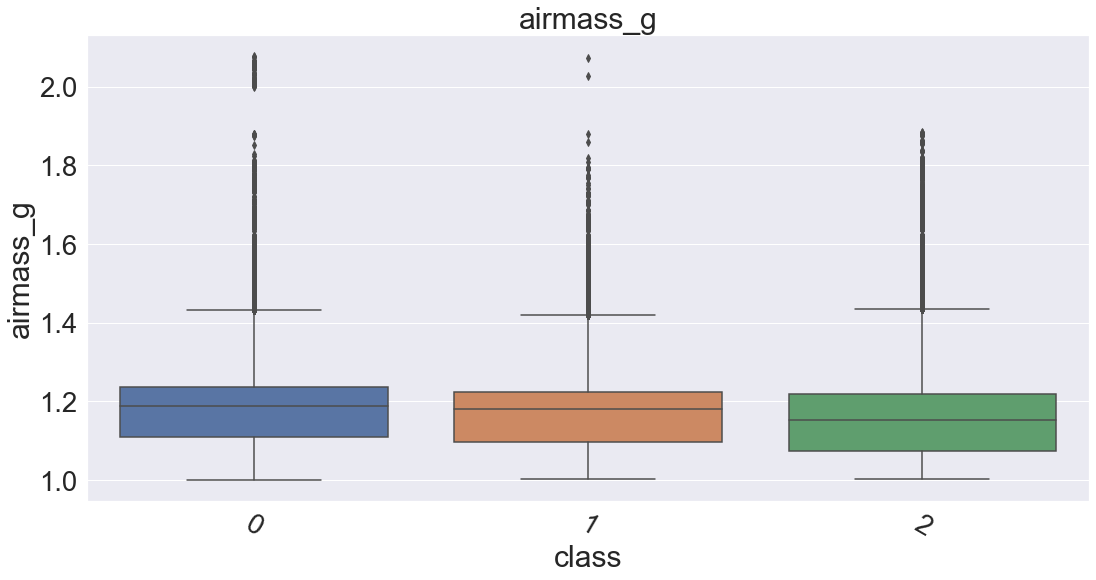

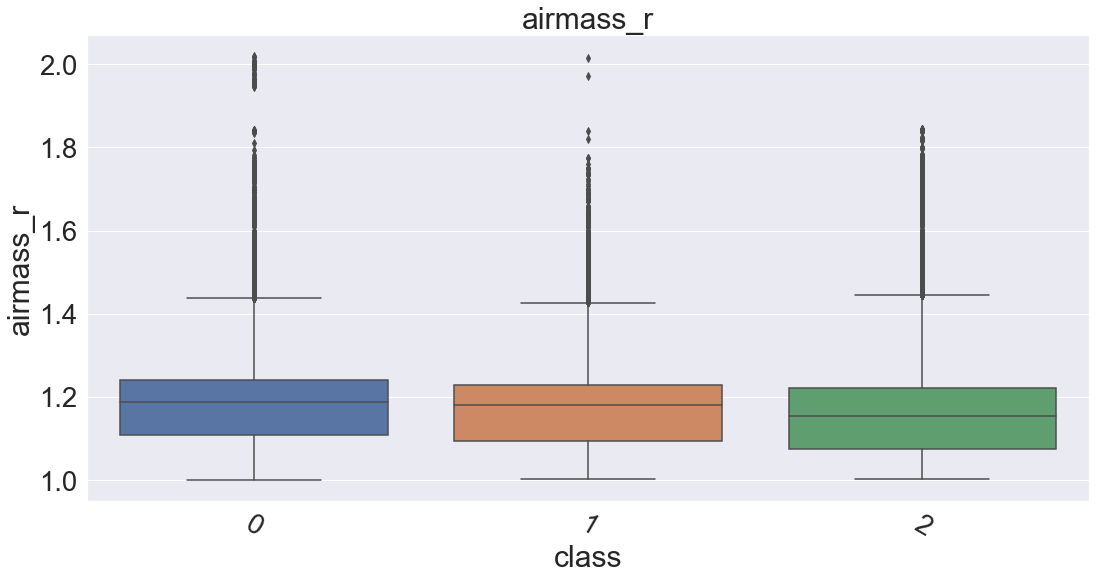

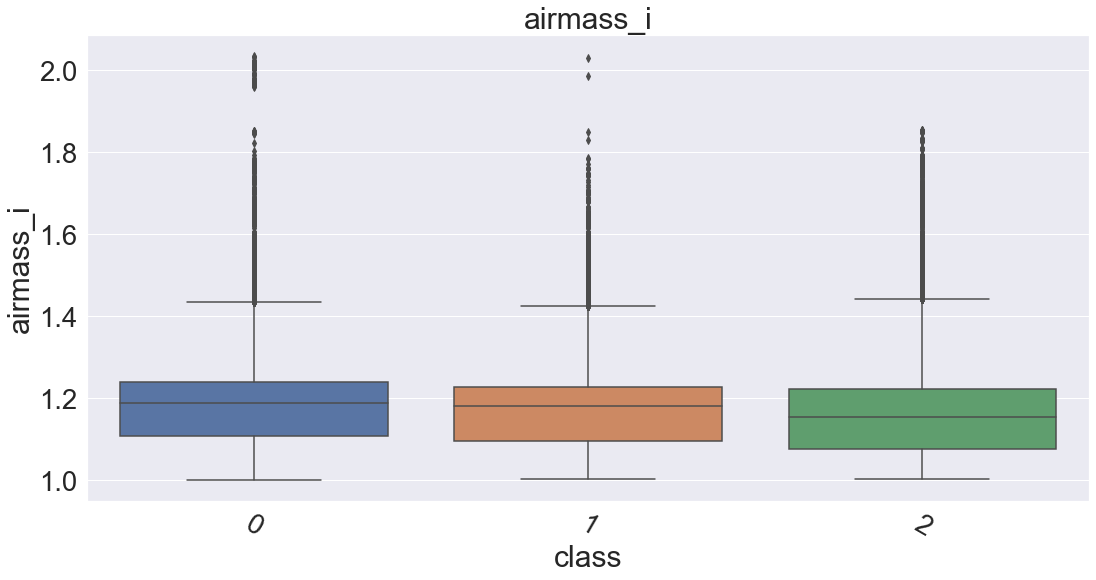

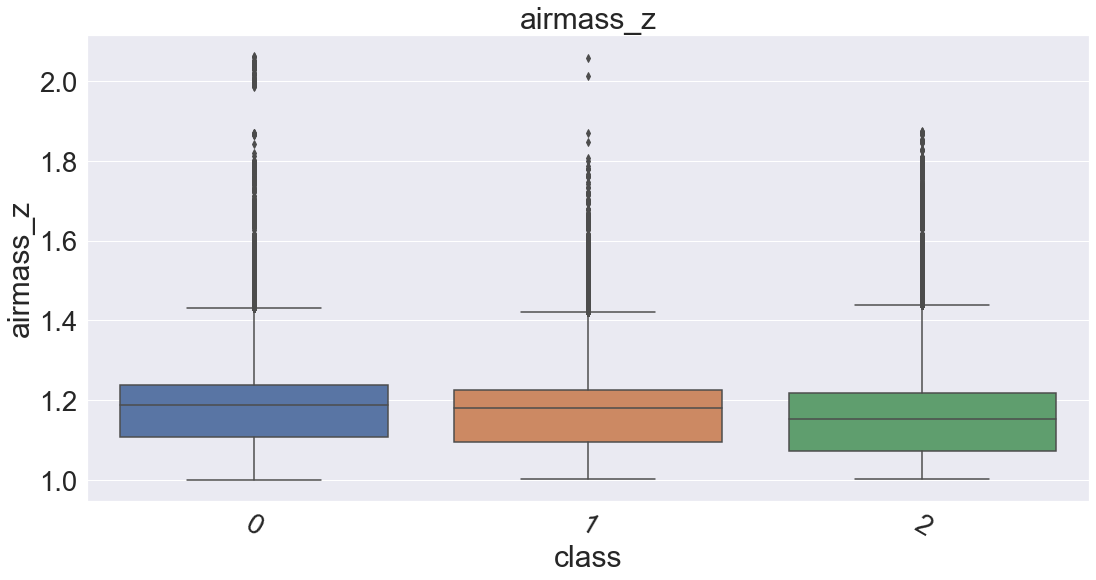

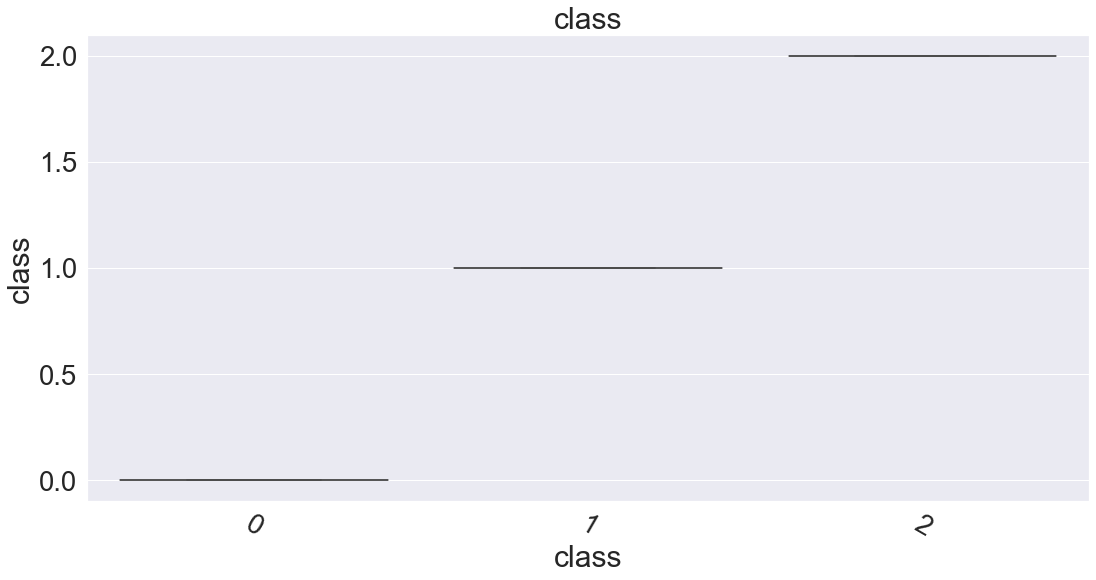

In [13]:
for col in df_train.columns[2:]:
    sns.boxplot(x='class', y=col, data=df_train)
    plt.title(col)
    plt.xticks(rotation=-30)
    plt.show()

같은 측정 방법끼리는 유사한 분포를 보임

# 시계열 관점에서 EDA

연속하는 파장을 갖고 측정한 데이터이므로 Sequantial한 데이터로 볼 수 있음.

In [14]:
wave_columns = df_train.columns.drop(['nObserve','nDetect','class','redshift'])

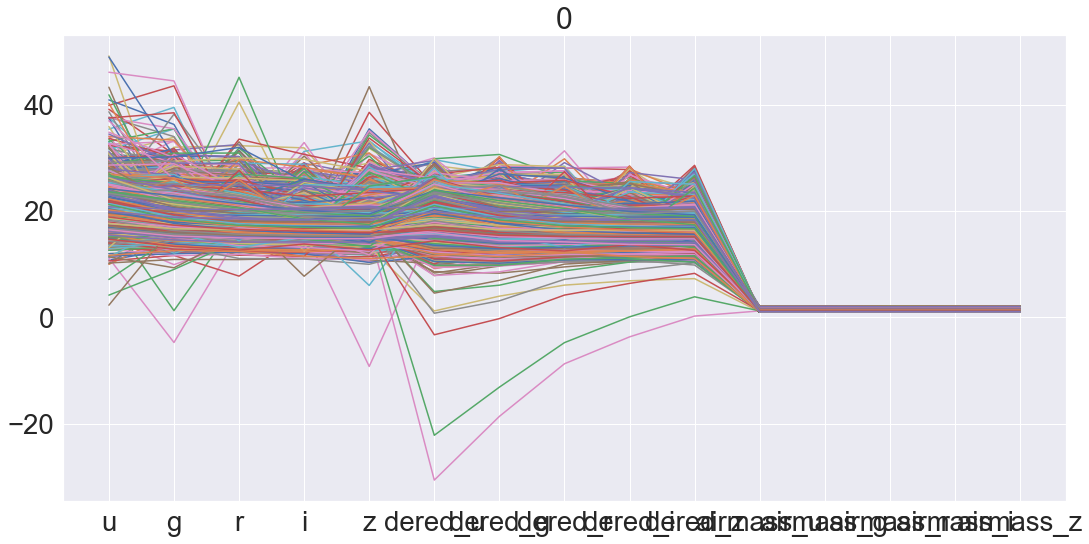

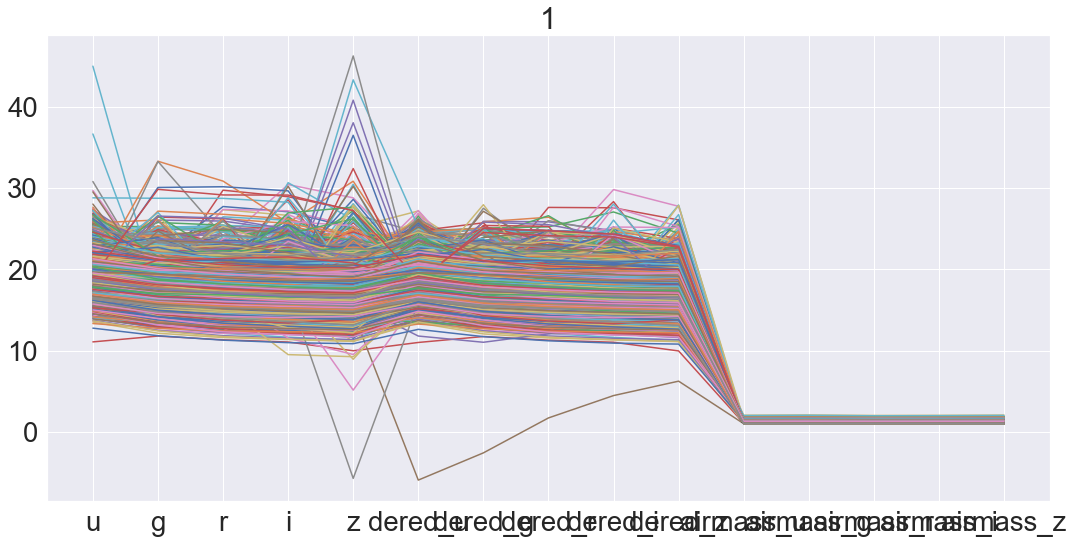

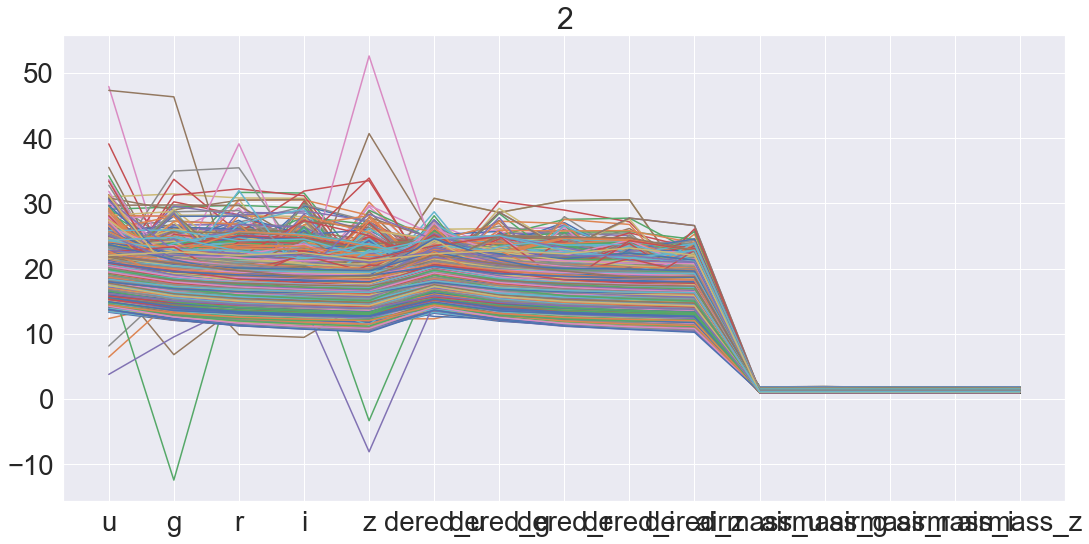

In [15]:
for t in df_train['class'].unique():
    a = df_train[df_train['class']==t]
    plt.plot(a[wave_columns].T)
    plt.title(t)
    plt.show()

class별로 구분되는 그래프를 확인할 수 없음.

가능한 변수들은 다음과 같다고함.

앞뒤 포인트의 차이(5개 포인트 간격까지)
20개 포인트 랭킹

# 변수 생성

ver1: 앞뒤 컬럼의 차이를 변수로 생성

ver2: 5개 컬럼 전의 컬럼과의 차이까지 변수로 생성

## Ver1

In [16]:
for j in range(14):
    name = 'diff_' + str(wave_columns[j+1]) + '_' + str(wave_columns[j])
    df_train[name] = df_train[wave_columns[j+1]] - df_train[wave_columns[j]]
    df_test[name] = df_test[wave_columns[j+1]] - df_test[wave_columns[j]]
    print(wave_columns[j+1], ' - ', wave_columns[j], j)

g  -  u 0
r  -  g 1
i  -  r 2
z  -  i 3
dered_u  -  z 4
dered_g  -  dered_u 5
dered_r  -  dered_g 6
dered_i  -  dered_r 7
dered_z  -  dered_i 8
airmass_u  -  dered_z 9
airmass_g  -  airmass_u 10
airmass_r  -  airmass_g 11
airmass_i  -  airmass_r 12
airmass_z  -  airmass_i 13


In [17]:
# 15포인트 랭킹

mag_rank_tr = df_train[wave_columns].rank(axis=1)
mag_rank_tt = df_test[wave_columns].rank(axis=1)

rank_col = []
for col in df_train[wave_columns].columns:
    col = col + '_rank'
    rank_col.append(col)
mag_rank_tr.columns = rank_col
mag_rank_tt.columns = rank_col

df_train = pd.concat([df_train, mag_rank_tr], axis=1)
df_test = pd.concat([df_test,mag_rank_tt], axis=1)

In [18]:
# 측정방법별 파장 차이 비교 변수

diff_col = []
for col in ['u','g','r','i','z']:
    for i in range(2):
        diff_col.append(col + '_' + str(i))

mag_wave_diff_tr = pd.DataFrame(np.zeros((df_train.shape[0], 10)), index=df_train.index)
mag_wave_diff_tt = pd.DataFrame(np.zeros((df_test.shape[0],10)), index=df_test.index)

for i in range(0,10,5):
    for j in range(5):
        mag_wave_diff_tr.loc[:, j+i] = df_train[wave_columns[j]] - df_train[wave_columns[5+j+i]]
        mag_wave_diff_tt.loc[:, j+i] = df_test[wave_columns[j]] - df_test[wave_columns[5+j+i]]
        print(wave_columns[j], ' - ', wave_columns[5+j+i],i+j)

u  -  dered_u 0
g  -  dered_g 1
r  -  dered_r 2
i  -  dered_i 3
z  -  dered_z 4
u  -  airmass_u 5
g  -  airmass_g 6
r  -  airmass_r 7
i  -  airmass_i 8
z  -  airmass_z 9


In [19]:
mag_wave_diff_tr.columns = diff_col
mag_wave_diff_tt.columns = diff_col

df_train = pd.concat([df_train, mag_wave_diff_tr], axis=1)
df_test = pd.concat([df_test, mag_wave_diff_tt], axis=1)

In [20]:
df_train['nObserve'] = df_train['nObserve'].apply(np.log1p)
df_test['nObserve'] = df_test['nObserve'].apply(np.log1p)

df_train['d_obs_det'] = df_train['nObserve'] - df_train['nDetect']
df_test['d_obs_det'] = df_test['nObserve'] - df_test['nDetect']

<AxesSubplot:>

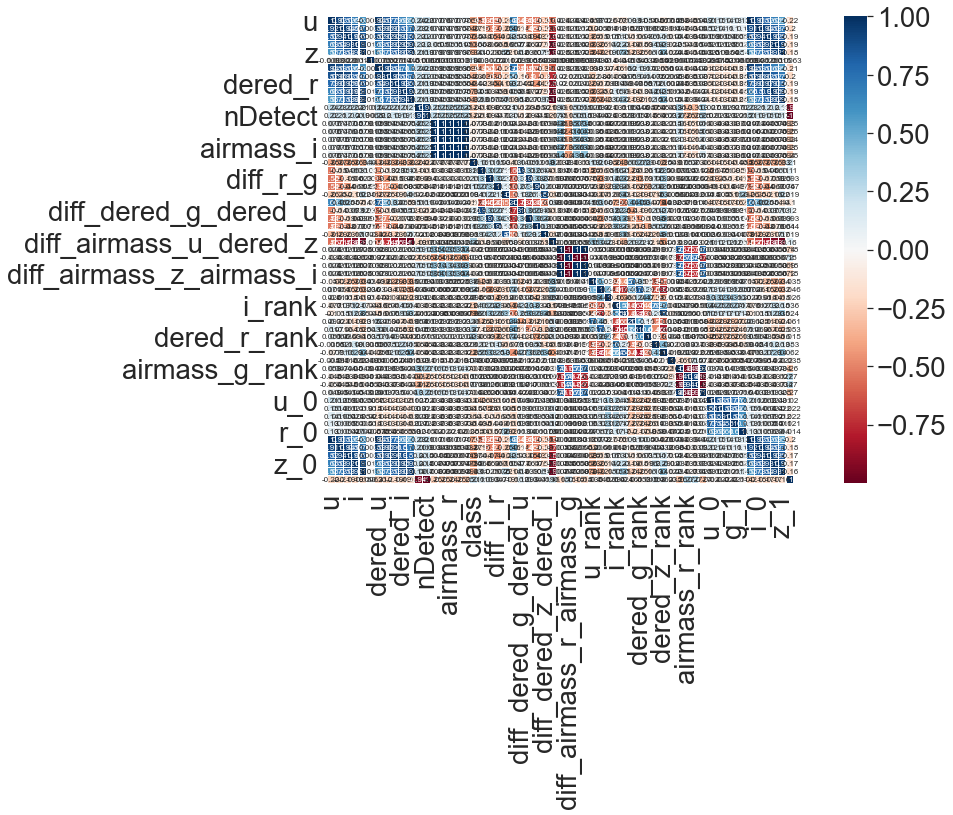

In [21]:
sns.heatmap(df_train.corr(), linewidths=0.1, vmax=1.0, square=True, cmap= plt.cm.RdBu, linecolor='white', annot=True, annot_kws={'size':8})

# dataset 생성

In [22]:
# train set
X = df_train.drop(columns=['class'], axis=1)
y = df_train.loc[:,'class']

# test set
test = df_test

# train set split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=SEED)

In [23]:
df_test

u        g        r        i        z    redshift  dered_u  \
id                                                                         
320000  19.1431  18.0172  17.4733  17.1144  16.9263  1.2130e-01  19.0750   
320001  18.7409  17.1705  16.3691  15.9865  15.7307 -6.6907e-05  15.0703   
320002  19.2980  17.8803  17.2221  16.8096  16.6352  1.1001e-01  19.1004   
320003  18.0775  17.1569  16.9041  16.8118  16.7955  2.9697e-05  17.9729   
320004  17.8325  16.7646  16.2135  15.8722  15.6621  6.8471e-02  17.7545   
...         ...      ...      ...      ...      ...         ...      ...   
399995  19.6734  18.6617  18.2708  18.1225  18.0627 -3.1726e-04  19.3361   
399996  21.5229  20.7283  20.6087  21.0049  20.8458  6.5455e-02  21.3993   
399997  19.3991  18.2411  18.1605  18.1978  18.2018 -8.4180e-04  18.9136   
399998  18.8997  17.6009  17.1329  16.8223  16.5946  4.2817e-02  18.7715   
399999  20.7587  20.4252  20.5362  20.7729  20.9698  2.8523e-04  20.4958   

        dered_g  dered_r  dered_i  dered_z  nObserve  nDetect  airmass_u  \
id                                                                         
320000  17.9550  17.4308  17.0838  16.9087    0.6931        1     1.1563   
320001  14.3098  14.3901  14.5160  14.6372    1.0986        2     1.0076   
320002  17.7726  17.1460  16.7497  16.5689    0.6931        1     1.3809   
320003  17.0735  16.8470  16.7700  16.7668    0.6931        1     1.1408   
320004  16.6794  16.1563  15.8315  15.6433    1.0986        2     1.1110   
...         ...      ...      ...      ...       ...      ...        ...   
399995  18.3933  18.0860  17.9861  17.9670    2.8904       17     1.1858   
399996  20.6399  20.5451  20.9507  20.7827    2.1972        4     1.2850   
399997  17.8753  17.9047  18.0043  18.0400    0.6931        1     1.1885   
399998  17.4880  17.0557  16.7660  16.5585    2.8904       17     1.1804   
399999  20.2181  20.3939  20.6696  20.9085    1.7918        5     1.1832   

        airmass_g  airmass_r  airmass_i  airmass_z  diff_g_u  diff_r_g  \
id                                                                       
320000     1.1515     1.1613     1.1588     1.1539   -1.1259   -0.5439   
320001     1.0074     1.0080     1.0078     1.0075   -1.5704   -0.8014   
320002     1.3905     1.3715     1.3761     1.3856   -1.4177   -0.6582   
320003     1.1408     1.1409     1.1408     1.1408   -0.9205   -0.2528   
320004     1.1077     1.1145     1.1127     1.1093   -1.0679   -0.5511   
...           ...        ...        ...        ...       ...       ...   
399995     1.1863     1.1855     1.1857     1.1861   -1.0117   -0.3909   
399996     1.2908     1.2793     1.2821     1.2878   -0.7946   -0.1196   
399997     1.1886     1.1885     1.1885     1.1885   -1.1580   -0.0806   
399998     1.1813     1.1797     1.1800     1.1809   -1.2989   -0.4680   
399999     1.1775     1.1889     1.1860     1.1803   -0.3335    0.1109   

        diff_i_r  diff_z_i  diff_dered_u_z  diff_dered_g_dered_u  \
id                                                                 
320000   -0.3588   -0.1881          2.1487               -1.1200   
320001   -0.3826   -0.2557         -0.6604               -0.7606   
320002   -0.4126   -0.1743          2.4651               -1.3277   
320003   -0.0923   -0.0163          1.1774               -0.8994   
320004   -0.3413   -0.2101          2.0924               -1.0750   
...          ...       ...             ...                   ...   
399995   -0.1483   -0.0598          1.2735               -0.9428   
399996    0.3962   -0.1591          0.5536               -0.7594   
399997    0.0373    0.0041          0.7118               -1.0383   
399998   -0.3105   -0.2278          2.1770               -1.2835   
399999    0.2367    0.1969         -0.4740               -0.2777   

        diff_dered_r_dered_g  diff_dered_i_dered_r  diff_dered_z_dered_i  \
id                                                                         
320000               -0.5241        